In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go
import nbformat
from plotly.subplots import make_subplots
import six  
import numpy as np
from numpy import random as rand 
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import plotly.figure_factory as ff


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import RobustScaler, PowerTransformer, FunctionTransformer, KBinsDiscretizer, OrdinalEncoder, OneHotEncoder, LabelEncoder,StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Predictive Modeling

### Baseline with Satisfaction Score

Load Data

In [4]:
# Load the CSV file into a DataFrame
df_model = pd.read_csv("Telco_data/df_model.csv",  sep=",")
# Display the DataFrame 
print(df_model.head())

  Customer ID Referred a Friend  Number of Referrals  Tenure in Months  \
0  8779-QRDMV                No                    0                 1   
1  7495-OOKFY               Yes                    1                 8   
2  1658-BYGOY                No                    0                18   
3  4598-XLKNJ               Yes                    1                25   
4  4846-WHAFZ               Yes                    1                37   

     Offer Phone Service  Avg Monthly Long Distance Charges Multiple Lines  \
0      NaN            No                               0.00             No   
1  Offer E           Yes                              48.85            Yes   
2  Offer D           Yes                              11.33            Yes   
3  Offer C           Yes                              19.76             No   
4  Offer C           Yes                               6.33            Yes   

  Internet Service Internet Type  ...  Total Revenue Churn Value  \
0              Yes

In [5]:
df_model.dtypes

Customer ID                           object
Referred a Friend                     object
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download                int64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming TV                          object
Streaming Movies                      object
Streaming Music                       object
Unlimited Data                        object
Contract                              object
Paperless Billing                     object
Payment Method                        object
Monthly Ch

Preprocess

In [6]:
# Identify and convert object type features to categorical
object_features = df_model.select_dtypes(include=['object']).columns.tolist()
for col in object_features:
    df_model[col] = df_model[col].astype('category')

# Verify the conversion
print(df_model.dtypes)

Customer ID                          category
Referred a Friend                    category
Number of Referrals                     int64
Tenure in Months                        int64
Offer                                category
Phone Service                        category
Avg Monthly Long Distance Charges     float64
Multiple Lines                       category
Internet Service                     category
Internet Type                        category
Avg Monthly GB Download                 int64
Online Security                      category
Online Backup                        category
Device Protection Plan               category
Premium Tech Support                 category
Streaming TV                         category
Streaming Movies                     category
Streaming Music                      category
Unlimited Data                       category
Contract                             category
Paperless Billing                    category
Payment Method                    

In [7]:
# Ensure 'Satisfaction Score' is also treated as a categorical variable
df_model['Satisfaction Score'] = df_model['Satisfaction Score'].astype('category')

In [8]:
numeric_var =['Age','Number of Dependents','Number of Referrals','Tenure in Months','Avg Monthly Long Distance Charges','Avg Monthly GB Download',
              'Monthly Charge','Total Charges','Total Refunds','Total Extra Data Charges','Total Long Distance Charges','Total Revenue'] 

categoric_var = ['Referred a Friend', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Gender', 'Offer']


ordinal_var = ['Satisfaction Score']


Models

In [9]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=3000, penalty='l2', C=0.1, random_state=42),  # Stronger L2 regularization
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Limit the depth of the trees
        min_samples_split=10,  # Require more samples to split nodes
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=6,  # Limit the depth of the trees
        min_child_weight=5,  # Increase the minimum child weight
        subsample=0.8,  # Use a fraction of the data for each tree
        random_state=42
    )
}

Cross-validation

In [10]:
# Split dataset
X = df_model[numeric_var + categoric_var + ordinal_var]
y = df_model['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)



# Encode categorical data to numeric, scale numeric data (without handling missing values) - gives same results
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoric_var),
        ('num', StandardScaler(), numeric_var),
        ('ord', OrdinalEncoder(), ordinal_var)

    ]) 




# Cross-validation
cv_df = []
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    score = cross_validate(model_pipe, X_train, y_train, cv=10, return_train_score=False, scoring=['roc_auc', 'f1', 'recall', 'precision'])
    mean_score = []
    for i in score.values():
        mean_score.append(round(np.mean(i), 3))
    cv_df.append(pd.DataFrame({'Attribute': [i for i in score.keys()], f'{name}': mean_score }))

score_before = pd.DataFrame(columns=['Attribute'])
for i in cv_df:
    score_before = score_before.merge(right=i, on='Attribute', how='outer')
score_before = score_before.loc[2:].reset_index(drop=True)

print(score_before)

        Attribute  Logistic Regression  Random Forest  XGBoost
0         test_f1                0.923          0.918    0.920
1  test_precision                0.951          0.977    0.935
2     test_recall                0.897          0.866    0.907
3    test_roc_auc                0.992          0.984    0.990


Fitting and Comparing test and train accuracies and errors

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [12]:
# Initialize a list to store results
results = []

# Fitting the models and evaluating on the test set
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    # Predictions and performance on the training set
    y_train_pred = model_pipe.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_error = 1 - train_accuracy  # Calculate training error
    
    if hasattr(model_pipe, "predict_proba"):
        y_train_pred_proba = model_pipe.predict_proba(X_train)[:, 1]
        train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    else:
        train_roc_auc = None

    # Predictions and performance on the test set
    y_test_pred = model_pipe.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_error = 1 - test_accuracy  # Calculate testing error
    
    if hasattr(model_pipe, "predict_proba"):
        y_test_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
        test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    else:
        test_roc_auc = None

    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Error': train_error,  # Store training error
        'Test Error': test_error,    # Store testing error
        'Train ROC AUC': train_roc_auc,
        'Test ROC AUC': test_roc_auc
    })
    
    print(f"Classification report for {name} on test set:")
    print(classification_report(y_test, y_test_pred))
    print("="*60)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

Classification report for Logistic Regression on test set:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       777
           1       0.97      0.89      0.93       280

    accuracy                           0.96      1057
   macro avg       0.97      0.94      0.95      1057
weighted avg       0.96      0.96      0.96      1057

Classification report for Random Forest on test set:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       777
           1       0.98      0.85      0.91       280

    accuracy                           0.95      1057
   macro avg       0.96      0.92      0.94      1057
weighted avg       0.96      0.95      0.95      1057

Classification report for XGBoost on test set:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       777
           1       0.93      0.91      0.92       280

    accuracy           

Learning curves

In [14]:
# Define a function to plot the learning curve with a specific scoring metric
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring if scoring else "Score")  # Display the scoring metric used
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt


In [16]:
from sklearn.model_selection import learning_curve

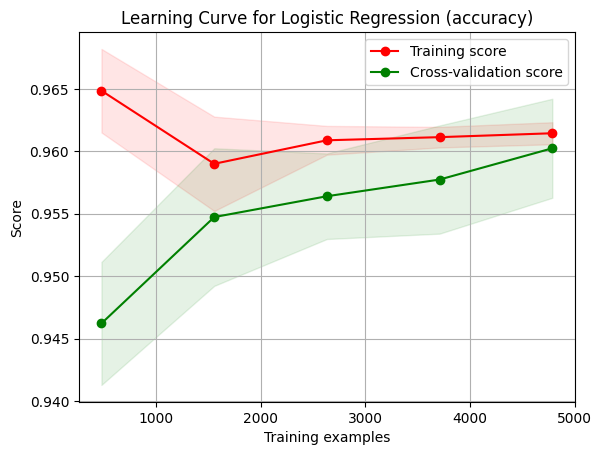

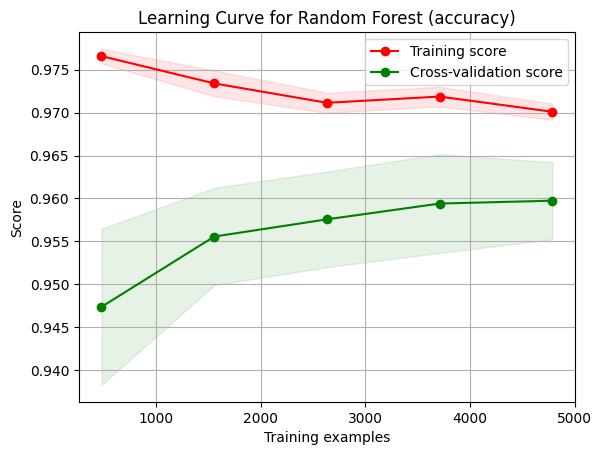

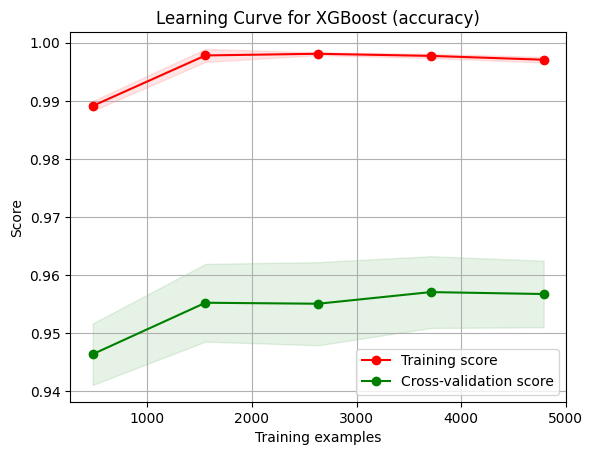

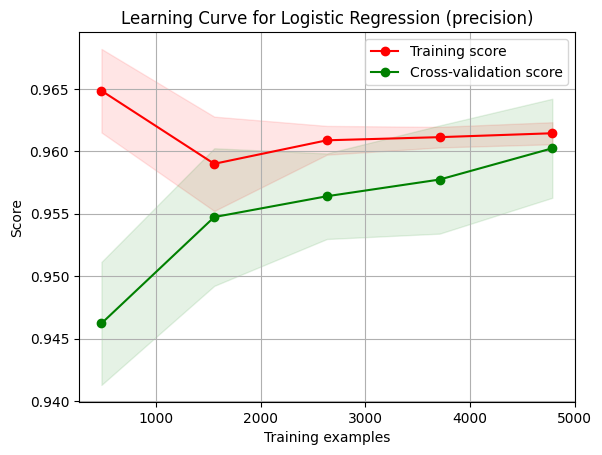

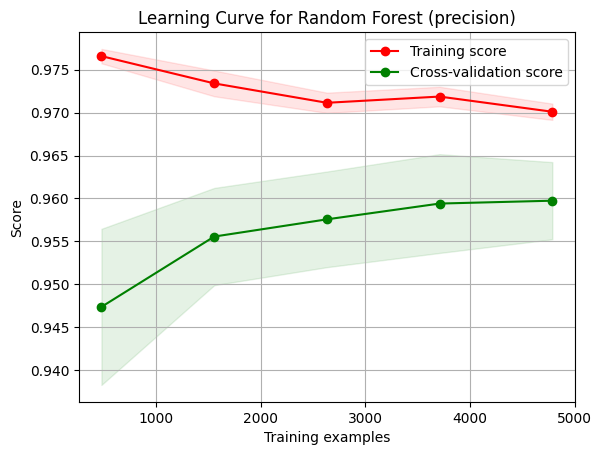

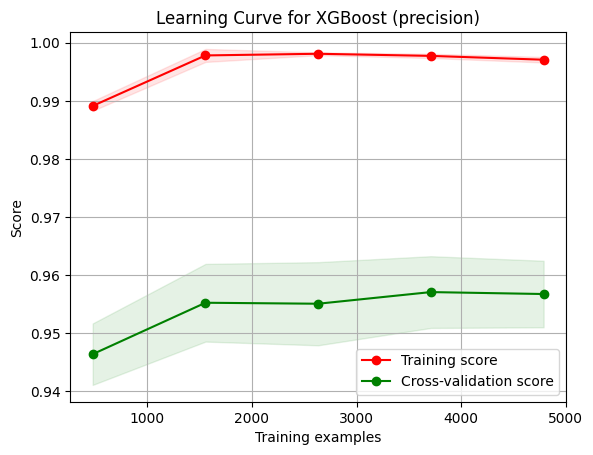

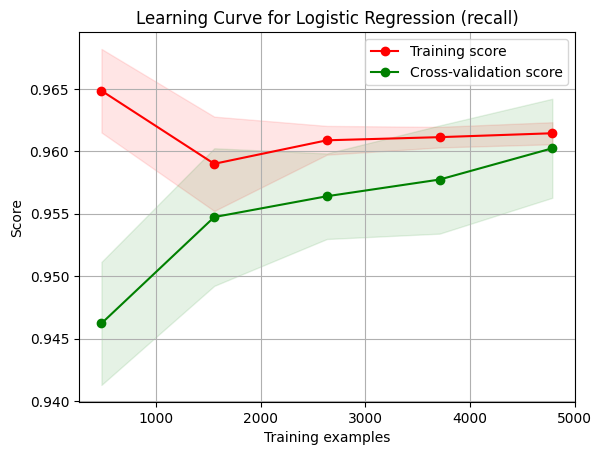

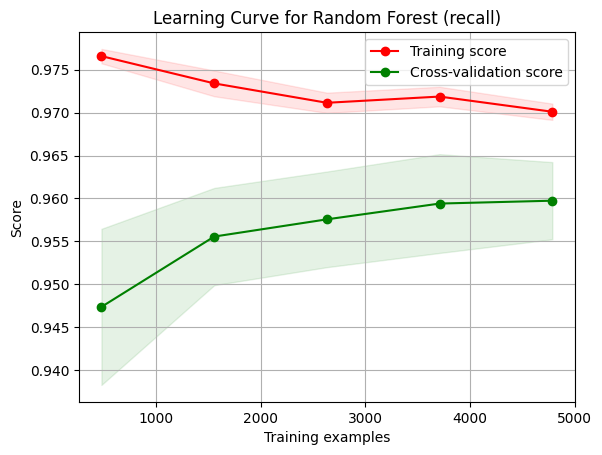

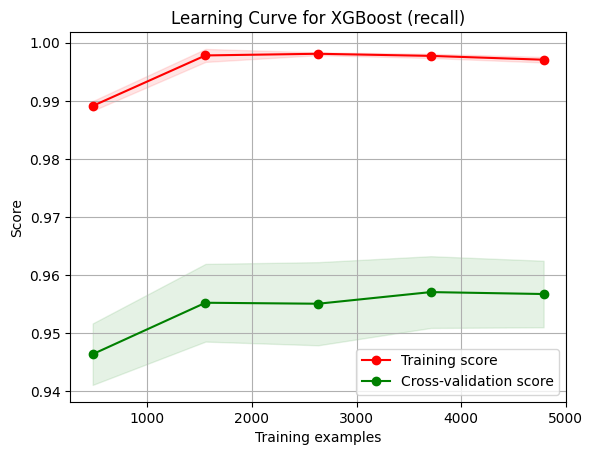

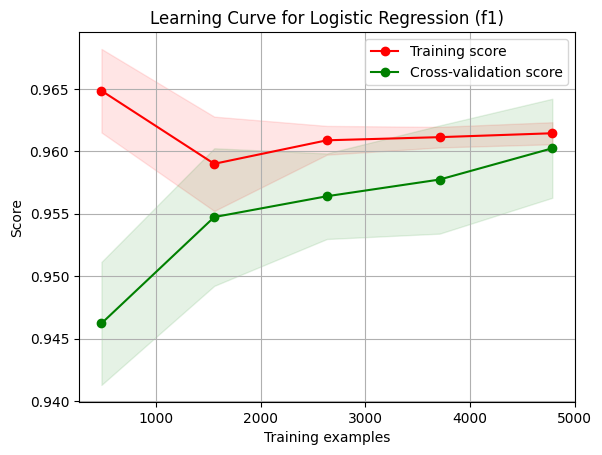

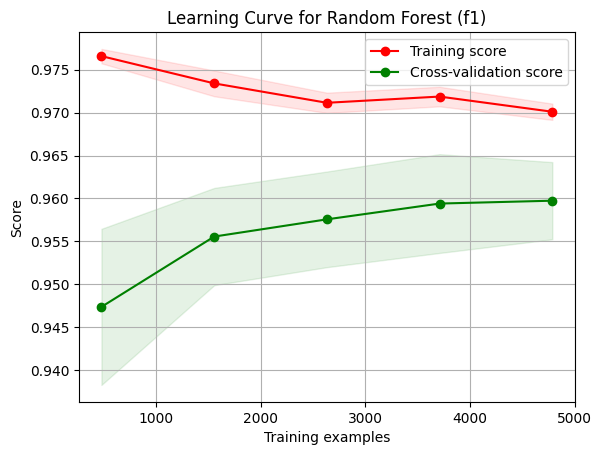

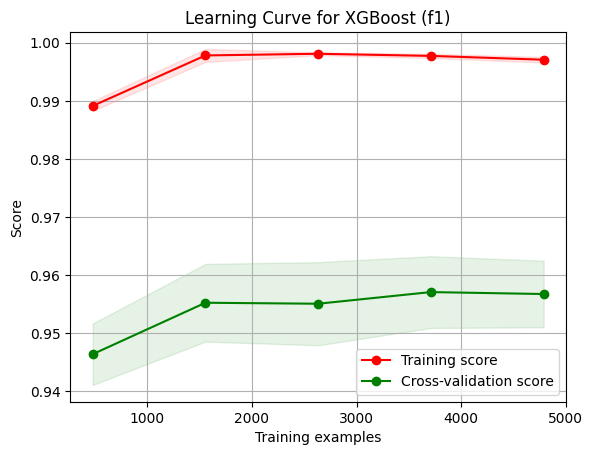

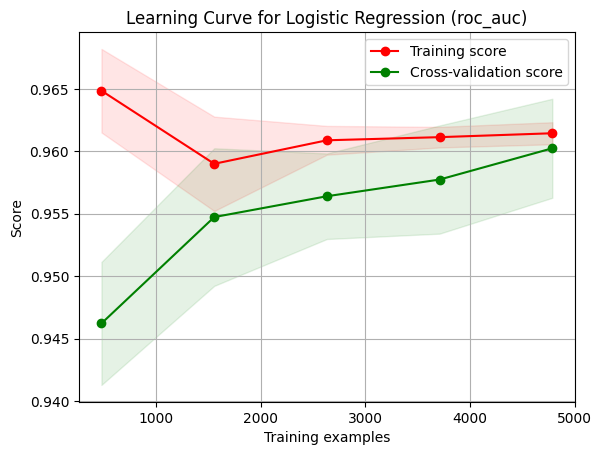

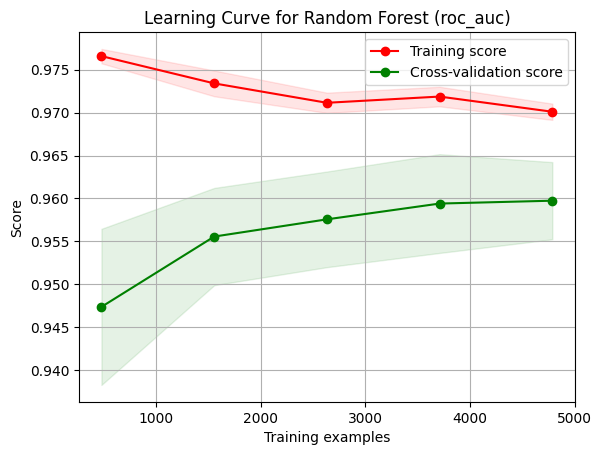

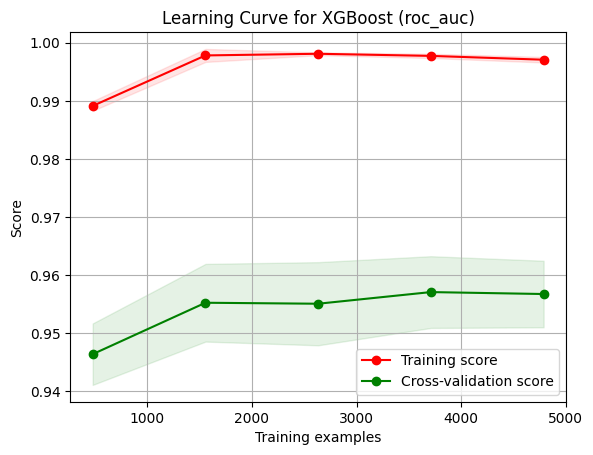

In [17]:
# Plot learning curves for different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics:
    # Plot learning curves for each model with scoring='recall'
    for name, model in models.items():
        model_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        plot_learning_curve(model_pipe, f'Learning Curve for {name} ({metric})', X_train, y_train, cv=5)
        plt.show()

Metrics


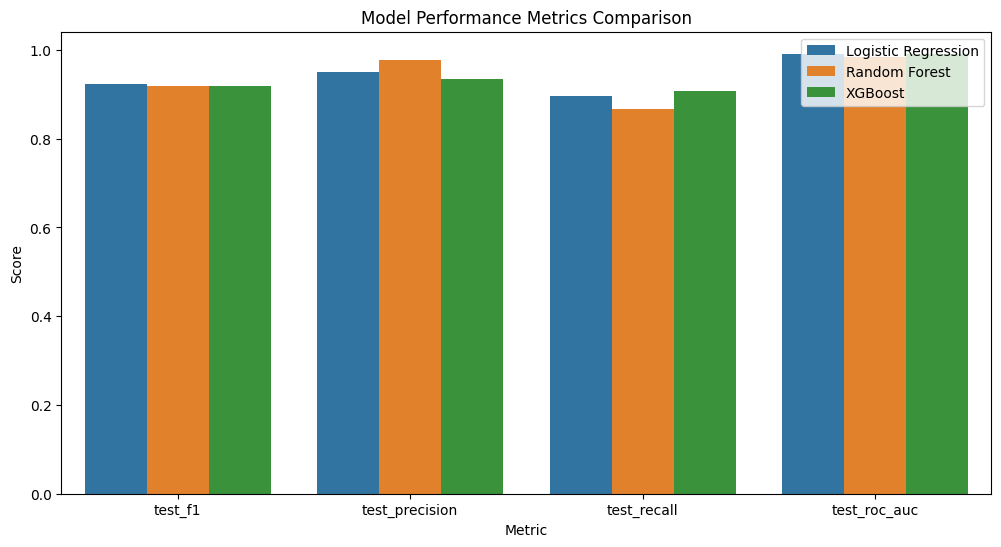

In [18]:
# Convert cross-validation results to DataFrame
cv_df_long = pd.melt(score_before, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Plot performance metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=cv_df_long)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

ROC AUC

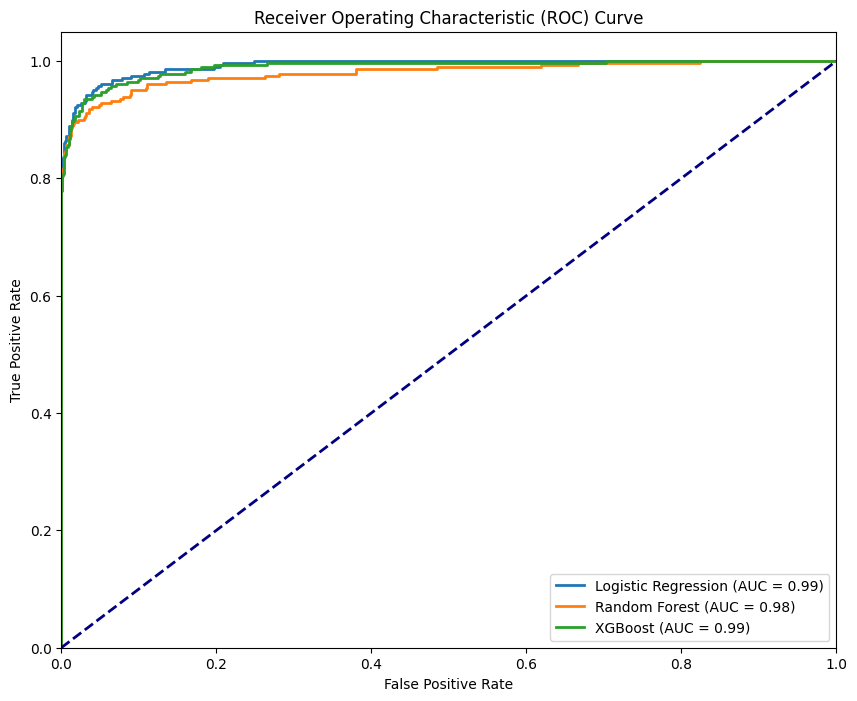

In [19]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Feature Importance

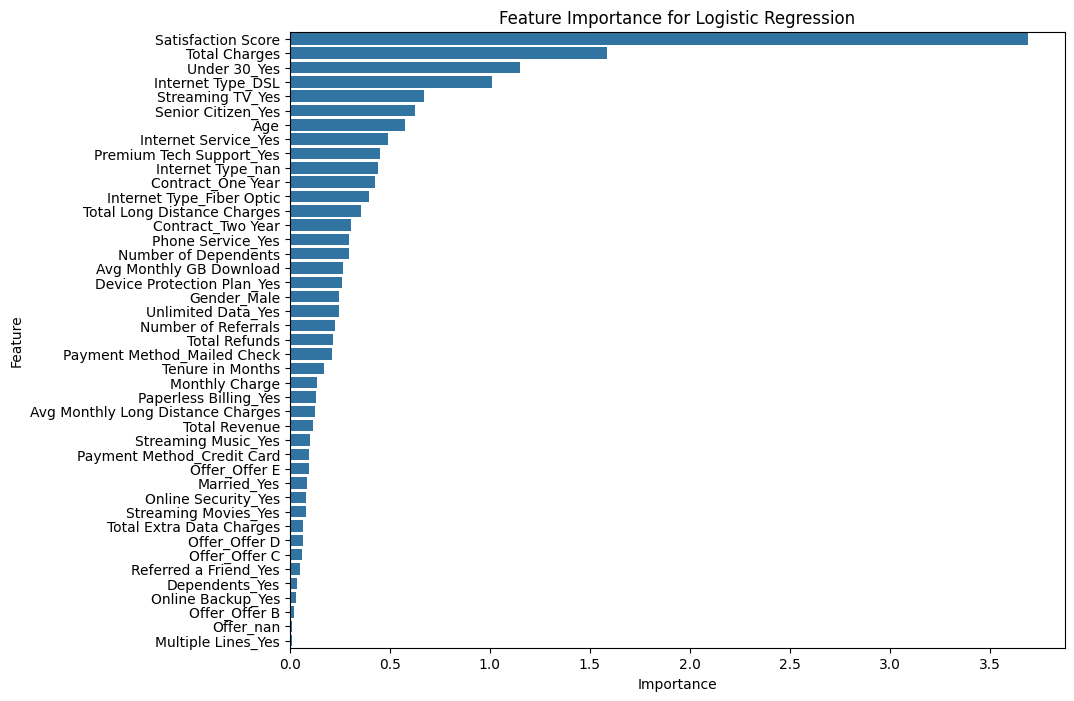

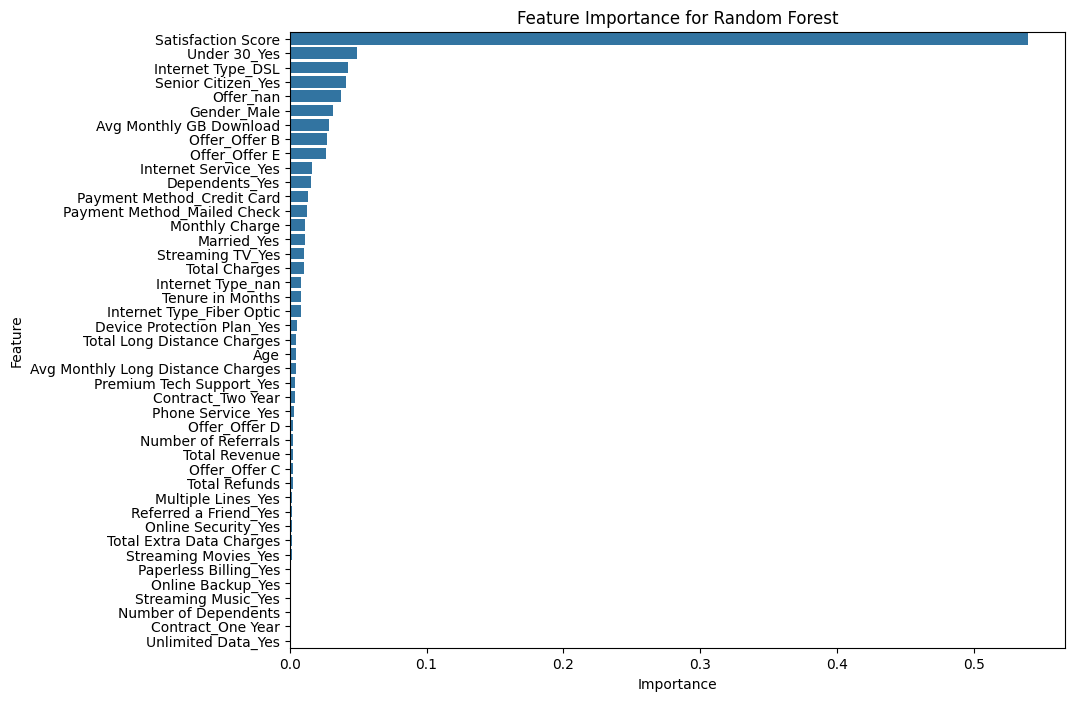

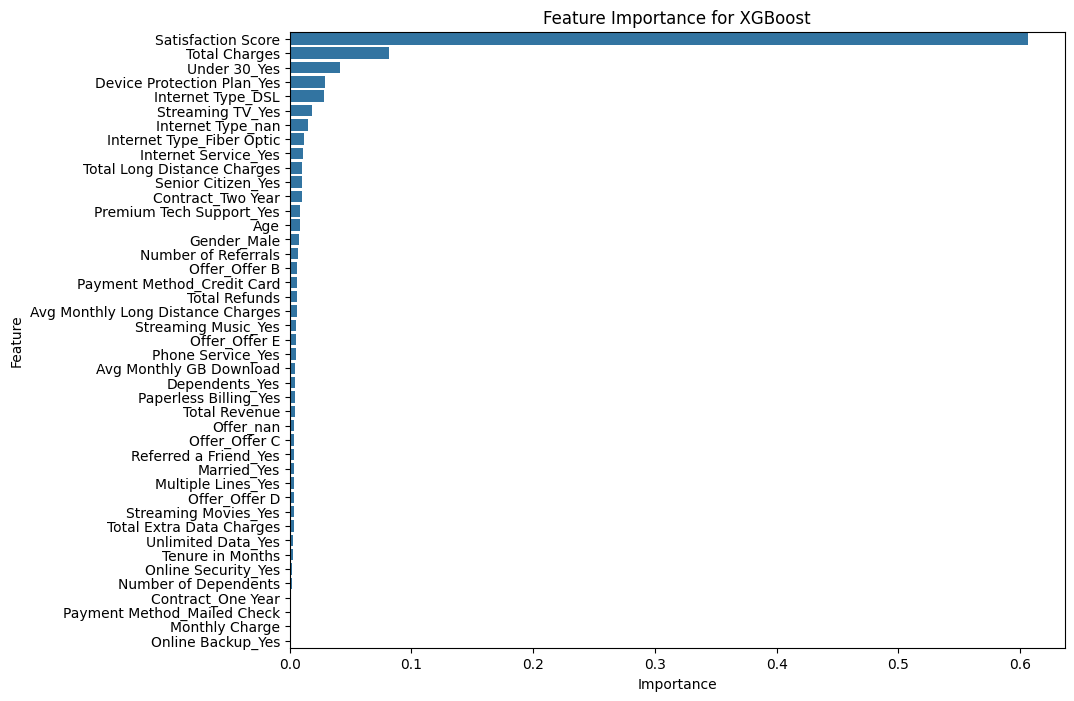

In [20]:
# Iterate over models and plot feature importance
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        feature_importances = model_pipe.named_steps['model'].feature_importances_
    elif isinstance(model, LogisticRegression):
        # Logistic Regression
        feature_importances = np.abs(model_pipe.named_steps['model'].coef_[0])
    else:
        # Skip models that don't have feature importances or coefficients
        continue
    
    # Get feature names
    cat_feature_names = model_pipe.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categoric_var)
    ord_feature_names = ordinal_var  # Ordinal features retain their original names
    feature_names = numeric_var + list(cat_feature_names) + ord_feature_names
    
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance for {name}')
    plt.show()

### Baseline without Satisfaction Score

In [21]:
numeric_var =['Age','Number of Dependents','Number of Referrals','Tenure in Months','Avg Monthly Long Distance Charges','Avg Monthly GB Download',
              'Monthly Charge','Total Charges','Total Refunds','Total Extra Data Charges','Total Long Distance Charges','Total Revenue'] 


categoric_var = ['Referred a Friend', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Under 30', 'Senior Citizen', 'Married', 'Dependents', 'Gender', 'Offer']



Cross-validation

In [22]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=3000, penalty='l2', C=0.1, random_state=42),  # Stronger L2 regularization
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Limit the depth of the trees
        min_samples_split=10,  # Require more samples to split nodes
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=6,  # Limit the depth of the trees
        min_child_weight=5,  # Increase the minimum child weight
        subsample=0.8,  # Use a fraction of the data for each tree
        random_state=42
    )
}

# Split dataset
X = df_model[numeric_var + categoric_var]
y = df_model['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)



# Encode categorical data to numeric, scale numeric data (without handling missing values) - gives same results
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoric_var),
        ('num', StandardScaler(), numeric_var)
        

    ]) 




# Cross-validation
cv_df = []
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    score = cross_validate(model_pipe, X_train, y_train, cv=10, return_train_score=False, scoring=['roc_auc', 'f1', 'recall', 'precision'])
    mean_score = []
    for i in score.values():
        mean_score.append(round(np.mean(i), 3))
    cv_df.append(pd.DataFrame({'Attribute': [i for i in score.keys()], f'{name}': mean_score }))

score_before = pd.DataFrame(columns=['Attribute'])
for i in cv_df:
    score_before = score_before.merge(right=i, on='Attribute', how='outer')
score_before = score_before.loc[2:].reset_index(drop=True)

print(score_before)

        Attribute  Logistic Regression  Random Forest  XGBoost
0         test_f1                0.683          0.672    0.676
1  test_precision                0.721          0.757    0.707
2     test_recall                0.651          0.605    0.649
3    test_roc_auc                0.898          0.895    0.891


Model Fit on Test set & Comparing test and train accuracies

In [23]:
# Initialize a list to store results
results = []

# Fitting the models and evaluating on the test set
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    # Predictions and performance on the training set
    y_train_pred = model_pipe.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    if hasattr(model_pipe, "predict_proba"):
        y_train_pred_proba = model_pipe.predict_proba(X_train)[:, 1]
        train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    else:
        train_roc_auc = None

    # Predictions and performance on the test set
    y_test_pred = model_pipe.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    if hasattr(model_pipe, "predict_proba"):
        y_test_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
        test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    else:
        test_roc_auc = None

    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train ROC AUC': train_roc_auc,
        'Test ROC AUC': test_roc_auc
    })
    
    print(f"Classification report for {name} on test set:")
    print(classification_report(y_test, y_test_pred))
    print("="*60)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Classification report for Logistic Regression on test set:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       777
           1       0.74      0.69      0.71       280

    accuracy                           0.85      1057
   macro avg       0.81      0.80      0.81      1057
weighted avg       0.85      0.85      0.85      1057

Classification report for Random Forest on test set:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       777
           1       0.77      0.60      0.68       280

    accuracy                           0.85      1057
   macro avg       0.82      0.77      0.79      1057
weighted avg       0.84      0.85      0.84      1057

Classification report for XGBoost on test set:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       777
           1       0.69      0.66      0.68       280

    accuracy           

Learning Curves


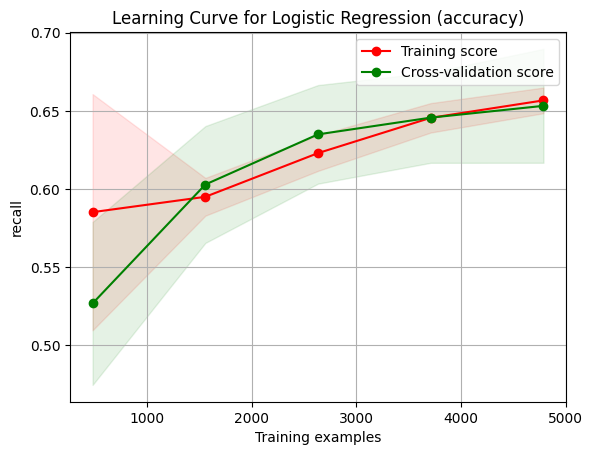

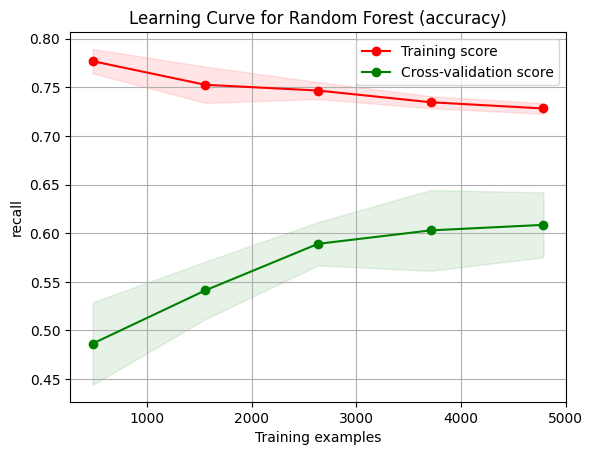

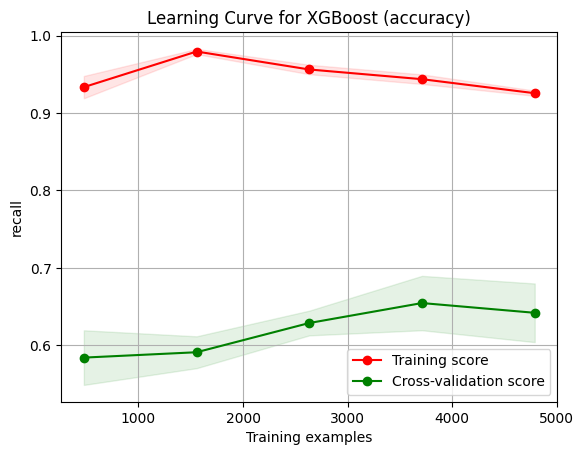

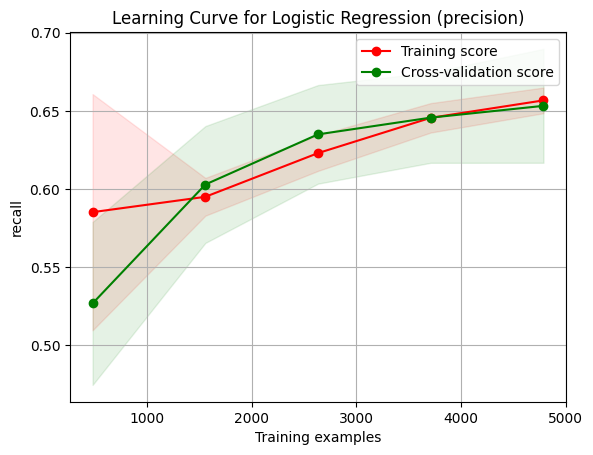

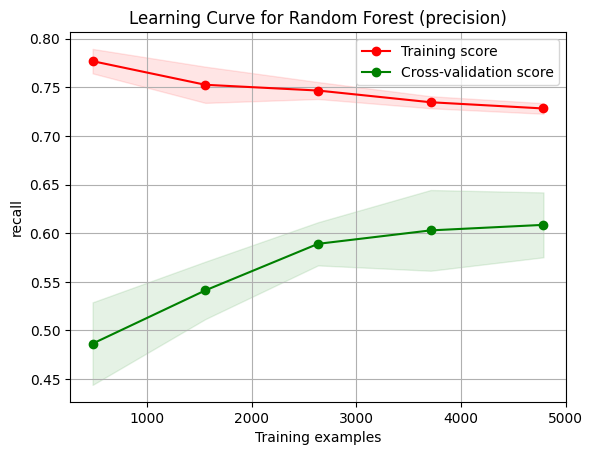

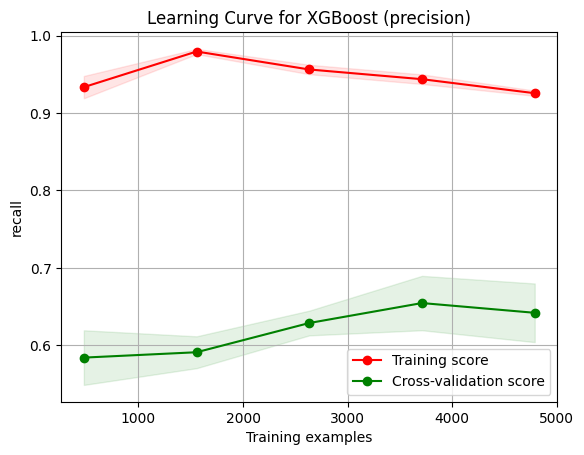

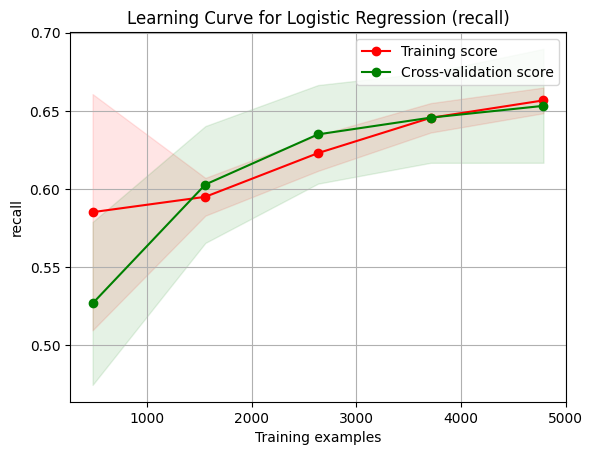

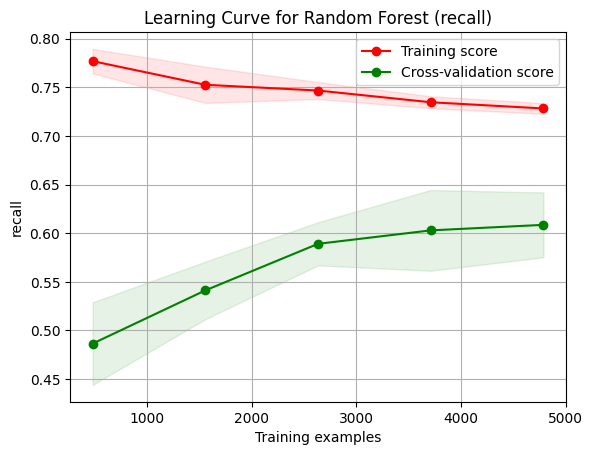

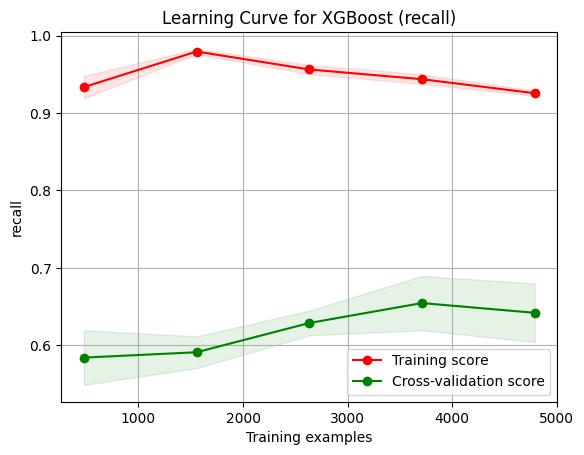

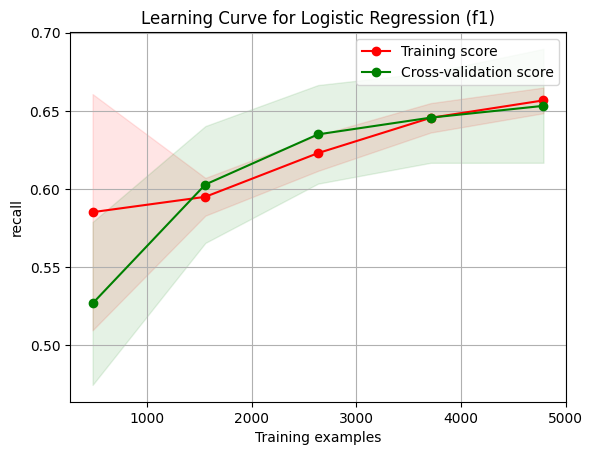

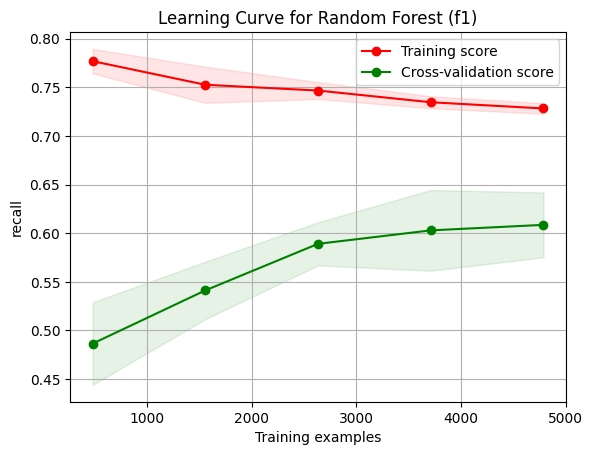

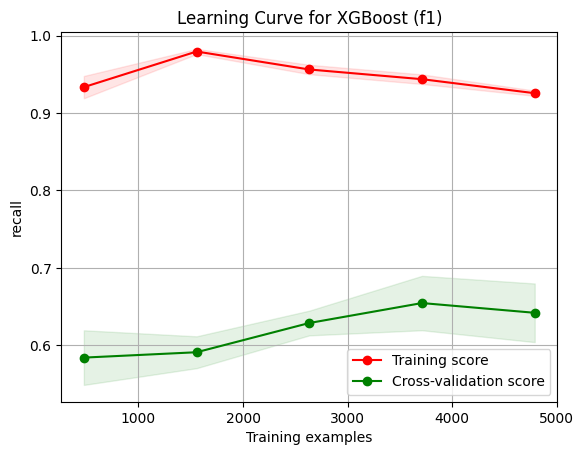

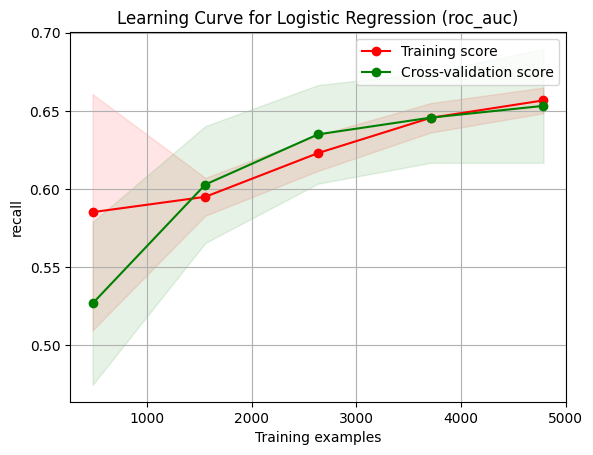

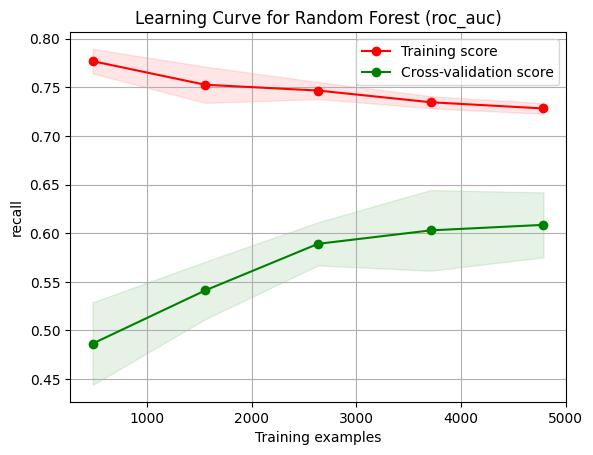

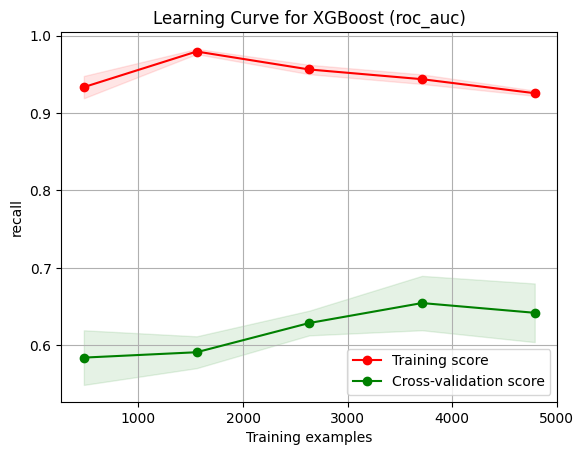

In [24]:
 
# Define a function to plot the learning curve with a specific scoring metric
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring if scoring else "Score")  # Display the scoring metric used
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt


# Plot learning curves for different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics:
# Plot learning curves for each model with scoring='recall'
    for name, model in models.items():
        model_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
        ('model', model)
        ])
        plot_learning_curve(model_pipe, f'Learning Curve for {name} ({metric})', X_train, y_train, cv=5, scoring='recall')
        plt.show()

Metrics

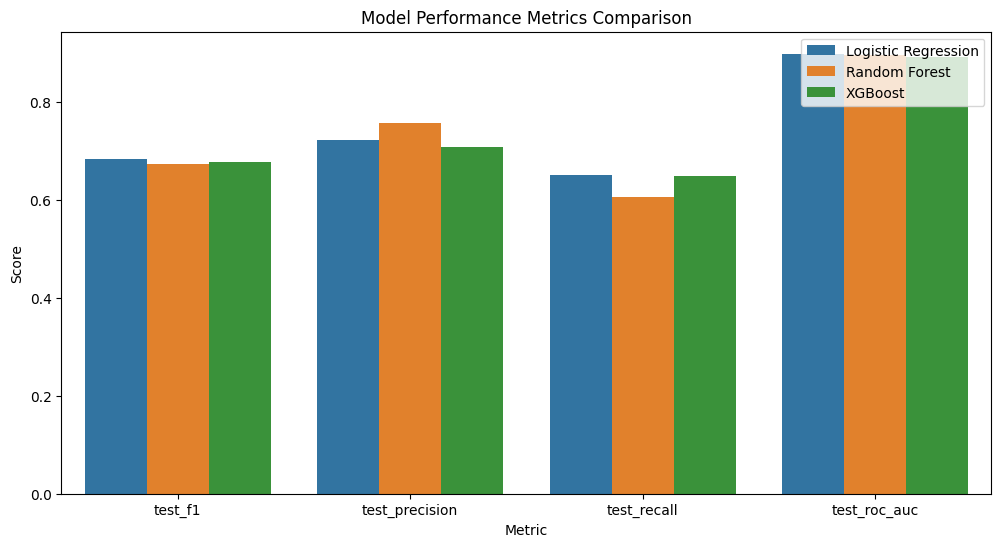

In [25]:
# Convert cross-validation results to DataFrame
cv_df_long = pd.melt(score_before, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Plot performance metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=cv_df_long)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

ROC AUC

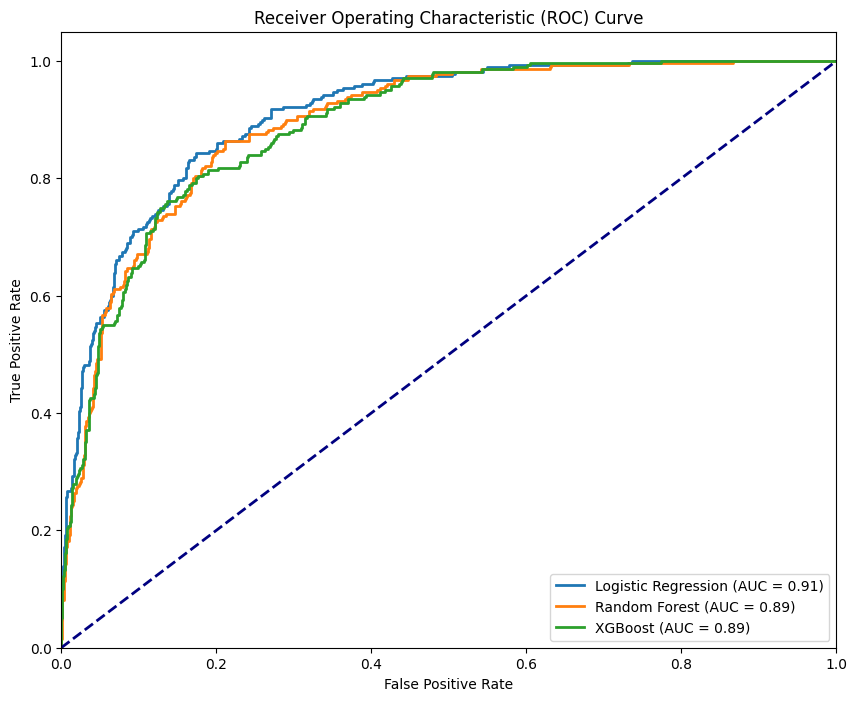

In [26]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Feature importance for tree-based models and logistic regression



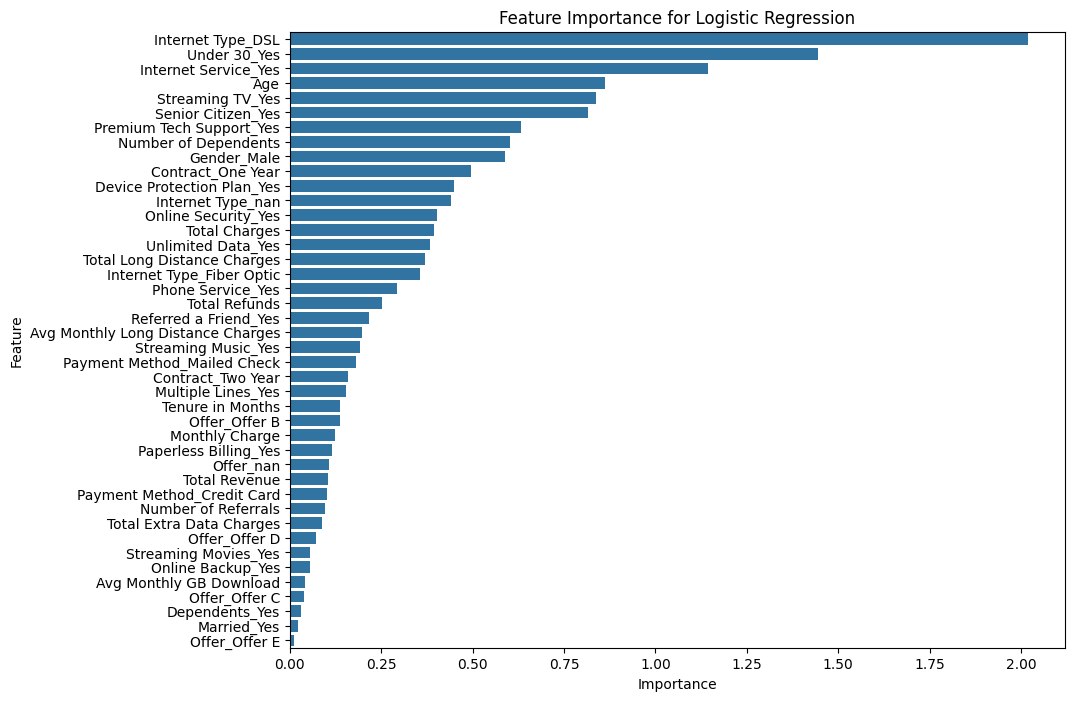

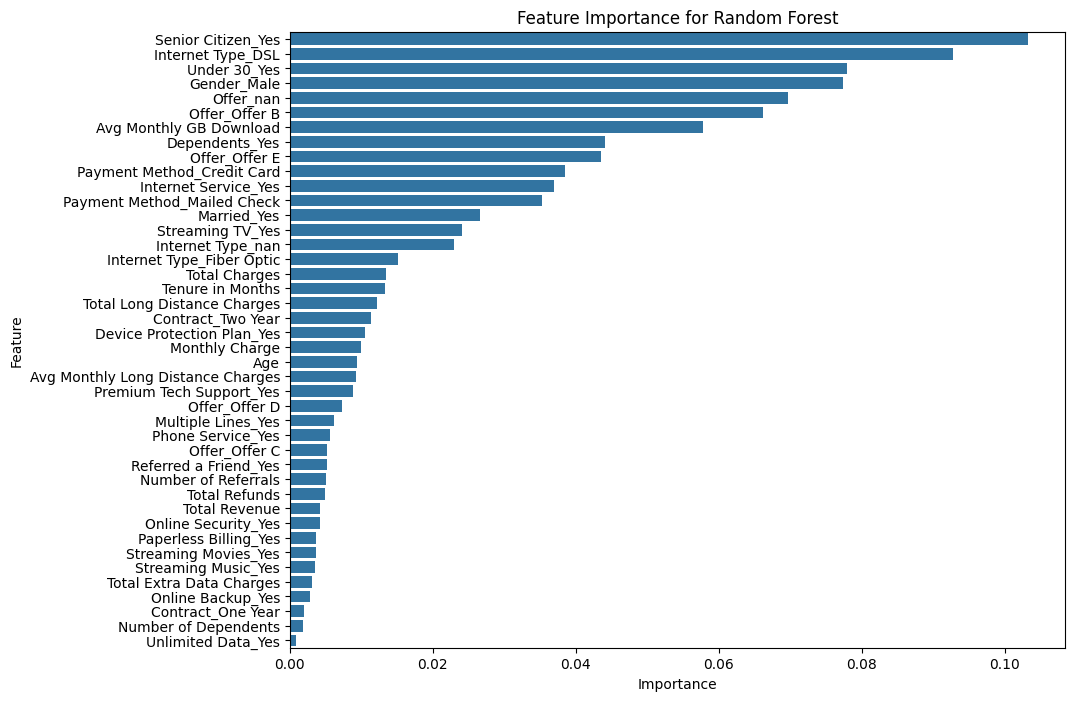

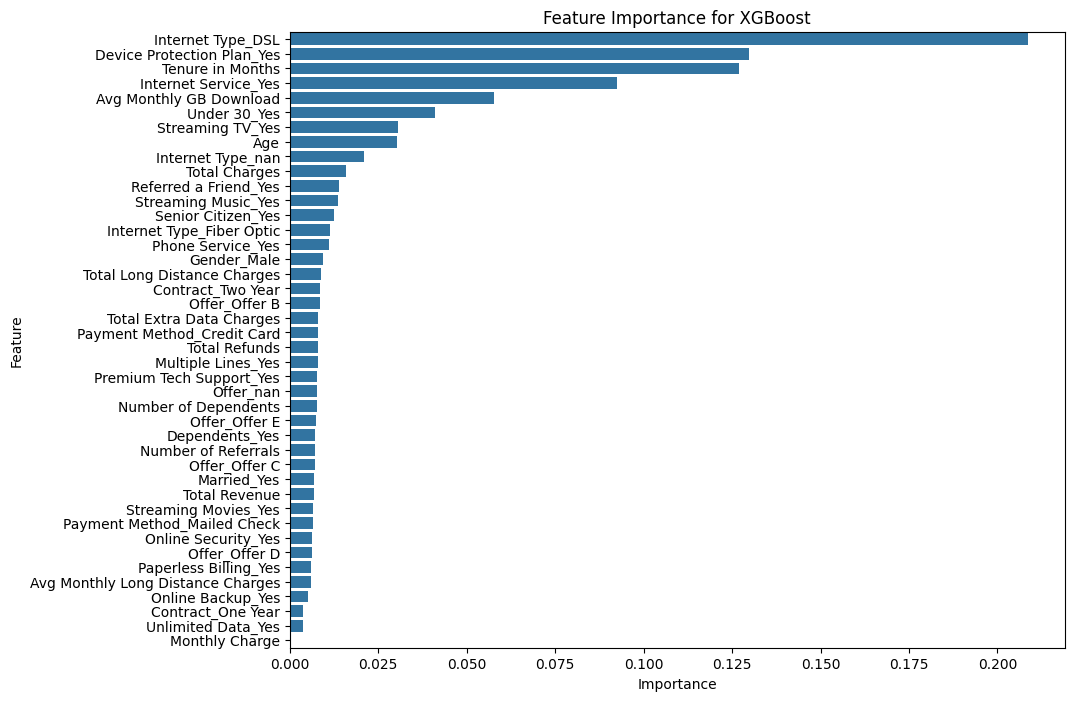

In [27]:
# Iterate over models and plot feature importance
for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        feature_importances = model_pipe.named_steps['model'].feature_importances_
    elif isinstance(model, LogisticRegression):
        # Logistic Regression
        feature_importances = np.abs(model_pipe.named_steps['model'].coef_[0])
    else:
        # Skip models that don't have feature importances or coefficients
        continue
    
    # Get feature names
    cat_feature_names = model_pipe.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categoric_var)
    feature_names = numeric_var + list(cat_feature_names)
    
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance for {name}')
    plt.show()

## Feature Selection

#### Extra Data Preprocessing 


In [28]:
from sklearn.feature_selection import SelectFromModel
from scipy.stats import skew, shapiro, normaltest

In [29]:
# Apply the encoding switch to df_model
#  ---> from ['Yes', 'No'] to  ['No', 'Yes']

columns_to_switch = ['Internet Service', 'Device Protection Plan', 'Streaming Movies', 'Paperless Billing', 'Senior Citizen']


for col in columns_to_switch:
    df_model[col] = pd.Categorical(df_model[col], categories=['No', 'Yes'], ordered=True)


# Define the categorical and numerical variables
binary_var = ['Referred a Friend', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 
              'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 
              'Streaming Music', 'Unlimited Data', 'Paperless Billing', 'Under 30', 'Senior Citizen', 
              'Married', 'Dependents','Offer', 'Payment Method', 'Gender', 'Contract']


# Verify the order and print unique values
for col in binary_var:
    print('Variable :', col)
    print('Unique Values :', df_model[col].unique())
    print('Number of Unique Values :', df_model[col].nunique())
    print('\n')

Variable : Referred a Friend
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values : 2


Variable : Phone Service
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values : 2


Variable : Multiple Lines
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values : 2


Variable : Online Security
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values : 2


Variable : Online Backup
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values : 2


Variable : Device Protection Plan
Unique Values : ['Yes', 'No']
Categories (2, object): ['No' < 'Yes']
Number of Unique Values : 2


Variable : Premium Tech Support
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values : 2


Variable : Streaming TV
Unique Values : ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
Number of Unique Values

In [43]:
# Define the order for ordinal variables
## excluded variables: 'Churn Value', 'Satisfaction Score', 'Customer ID', Adding 'Total Extra Data Charges' and 'Total Refunds' as categorical
ord_ = {
    'ord1': [['Married', 'Dependents', 'Referred a Friend', 'Phone Service', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data', 'Under 30', 'Online Security',
             'Online Backup','Streaming TV', 'Multiple Lines', 'Internet Service','Device Protection Plan', 'Streaming Movies', 'Paperless Billing', 'Senior Citizen',
             'Total Extra Data Charges','Total Refunds'], ['No', 'Yes']],
    'ord2': [['Internet Type'], ['None', 'DSL', 'Cable', 'Fiber Optic']], # MAKE SURE THE SPEED OF THE INTERNET TYPE INCREASING
    'ord3': [['Contract'], ['Month-to-Month', 'One Year', 'Two Year']]
    
}


nominal_var = ['Offer', 'Gender', 'Payment Method']


numeric_var = ['Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 
               'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Long Distance Charges', 
               'Total Revenue', 'Age', 'Number of Dependents']

##### Dealing with outliers

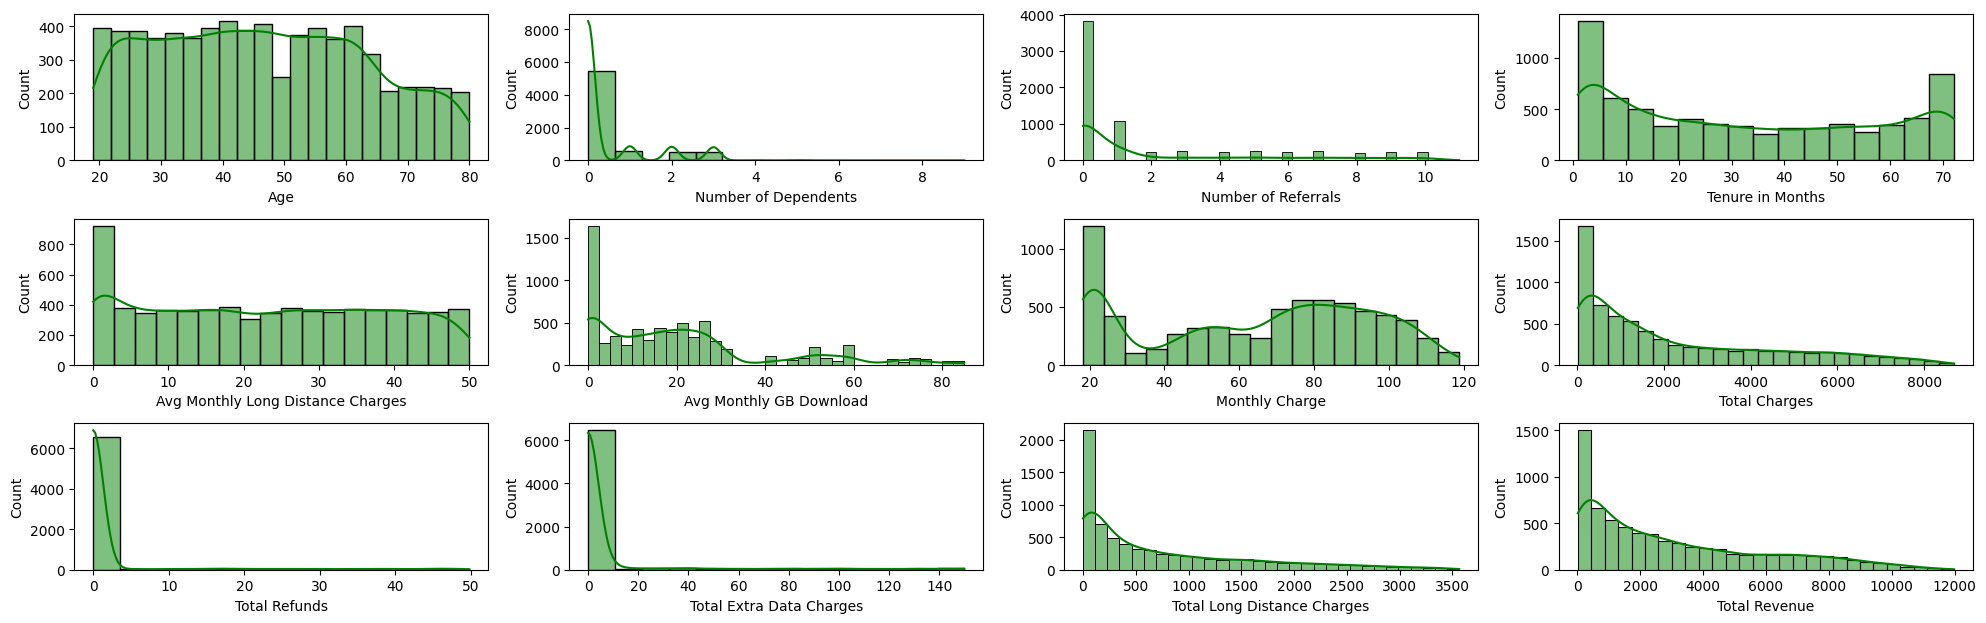

In [30]:
# function to find outliers
def find_outliers_IQR(Series):
   q1=Series.quantile(0.25)
   q3=Series.quantile(0.75)
   IQR=q3-q1 
   upper_bound = (q3+1.5*IQR) 
   lower_bound = (q1-1.5*IQR)
   outliers = Series[(Series<lower_bound) | (Series>upper_bound)]
   return outliers, lower_bound, upper_bound 

# plot data distributions
plt.figure(figsize=(20,10))
for i in enumerate(numeric_var):
  plt.subplot(5,4,i[0]+1)
  sns.histplot(df_model[i[1]], kde=True,color='green')
plt.tight_layout()
plt.show()

In [31]:
num_conc = pd.DataFrame({
    'Numeric Var':numeric_var,
    'Skewness':[ round(skew(df_model[i], bias=False),3) for i in numeric_var],
    'Shapiro P-val': [ round(shapiro(df_model[i].sample(3000))[1],5) for i in numeric_var] ,
    'Conclusion': [ 'Normal' if shapiro(df_model[i].sample(3000))[1] >= 0.05 else 'Non-Normal' for i in numeric_var],
    'Outlier Count': [find_outliers_IQR(df_model[i])[0].shape[0] for i in numeric_var],
    'Outlier %' : [ round((i / df_model.shape[0])*100,2) for i in [find_outliers_IQR(df_model[i])[0].shape[0] for i in numeric_var]]  
}).sort_values(by='Skewness', ignore_index=True)
display(num_conc,df_model[numeric_var].describe())

,Numeric Var,Skewness,Shapiro P-val,Conclusion,Outlier Count,Outlier %
0,Monthly Charge,-0.221,0.0,Non-Normal,0,0.00
1,Avg Monthly Long Distance Charges,0.049,0.0,Non-Normal,0,0.00
2,Age,0.162,0.0,Non-Normal,0,0.00
3,Tenure in Months,0.241,0.0,Non-Normal,0,0.00
4,Total Revenue,0.919,0.0,Non-Normal,21,0.30
5,Total Charges,0.964,0.0,Non-Normal,0,0.00
6,Avg Monthly GB Download,1.217,0.0,Non-Normal,362,5.14
7,Total Long Distance Charges,1.238,0.0,Non-Normal,196,2.78
8,Number of Referrals,1.446,0.0,Non-Normal,676,9.60
9,Number of Dependents,2.110,0.0,Non-Normal,1627,23.10


,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


Outliers: 'Number of Dependents', 'Total Extra Data Charges', 'Total Refunds' , 'Number of Referrals', 'Total Long Distance Charges','Avg Monthly GB Download','Total Revenue'

The following outlier operations will be carried out:
- For the feature 'Number of Dependents' all numbers above 3 will be changed to number 3.
- For the features 'Total Extra Data Charges' and 'Total Refunds' they will be minimized and changed to categorical data: all numbers 0 will be changed to 'No', the rest to 'Yes'.
- For other features the outlier will be considered as missing values ​​which will later be compiled using KNN Imputer.




In [32]:
# Spliting outlier variables
out_var1 = ['Total Refunds','Total Extra Data Charges'] 
out_var2 = ['Number of Dependents']
out_var3 = ['Number of Referrals','Total Long Distance Charges','Avg Monthly GB Download','Total Revenue']

##### Encoding to categorical

In [33]:
# Calculate the proportion of the values 0
for i in ['Total Extra Data Charges','Total Refunds']: 
    print( "{} == 0 :".format(i),df_model[i].value_counts().head(1)[0], '| {persen} %'.format(persen=round((df_model[i].value_counts().head(1)[0]/df_model.shape[0])*100,3)))
    print("{} != 0 :".format(i), df_model[df_model[i] !=0].shape[0], '| {persen} %'.format(persen=round((df_model[df_model[i] !=0].shape[0] / df_model.shape[0]) * 100,3)))
    print('\n') 

Total Extra Data Charges == 0 : 6315 | 89.663 %
Total Extra Data Charges != 0 : 728 | 10.337 %


Total Refunds == 0 : 6518 | 92.546 %
Total Refunds != 0 : 525 | 7.454 %




In [34]:
df_transform = df_model

In [35]:
# Recode the fetures with outliers to categorical (Yes and No categories)
df_transform['Total Extra Data Charges'] = df_transform['Total Extra Data Charges'].apply(lambda x: 'No' if x == 0 else 'Yes')
df_transform['Total Refunds'] = df_transform['Total Refunds'].apply(lambda x: 'No' if x == 0 else 'Yes')

In [36]:
# Chech the encoding worked
print(df_transform['Total Extra Data Charges'])

0       Yes
1        No
2        No
3        No
4        No
       ... 
7038     No
7039     No
7040     No
7041     No
7042     No
Name: Total Extra Data Charges, Length: 7043, dtype: object


In [37]:
# Verify the order and print unique values
binary_variables = ['Total Extra Data Charges','Total Refunds']

for col in binary_variables:
    print('Variable :', col)
    print('Unique Values :', df_transform[col].unique())
    print('Number of Unique Values :', df_transform[col].nunique())
    print('\n')

Variable : Total Extra Data Charges
Unique Values : ['Yes' 'No']
Number of Unique Values : 2


Variable : Total Refunds
Unique Values : ['No' 'Yes']
Number of Unique Values : 2




In [38]:
# Apply the encoding switch to df_model
#  ---> from ['Yes', 'No'] to  ['No', 'Yes']

columns_to_switch_2 = ['Total Extra Data Charges']


for col in columns_to_switch_2:
    df_transform[col] = pd.Categorical(df_transform[col], categories=['No', 'Yes'], ordered=True)

In [39]:
binary_variables = ['Total Extra Data Charges','Total Refunds']

# Verify the order and print unique values

for col in binary_variables:
    print('Variable :', col)
    print('Unique Values :', df_transform[col].unique())
    print('Number of Unique Values :', df_transform[col].nunique())
    print('\n')

Variable : Total Extra Data Charges
Unique Values : ['Yes', 'No']
Categories (2, object): ['No' < 'Yes']
Number of Unique Values : 2


Variable : Total Refunds
Unique Values : ['No' 'Yes']
Number of Unique Values : 2




##### IQR method

Caps the values of 'Number of Dependents' at 3 

Identifies outliers in specified columns using the IQR method and replaces values above the upper bound with NaN. 

Imputes the NaN values using the KNN imputer. 

In [40]:
from sklearn.impute import KNNImputer, SimpleImputer

In [44]:
# function to find outliers
def find_outliers_IQR(Series):
   q1=Series.quantile(0.25)
   q3=Series.quantile(0.75)
   IQR=q3-q1 
   upper_bound = (q3+1.5*IQR) 
   lower_bound = (q1-1.5*IQR)
   outliers = Series[(Series<lower_bound) | (Series>upper_bound)]
   return outliers, lower_bound, upper_bound 

# function handling outliers
def func_handling_outlier(X_train):
    # handling variable 2 outliers
    X_train['Number of Dependents'] = X_train['Number of Dependents'].apply(lambda i: 3 if i>3 else i) 
    # handling variable 3 outliers
    out_var3 = ['Number of Referrals','Total Long Distance Charges','Avg Monthly GB Download','Total Revenue']
    # upper bound
    upper_bound = []
    for i in out_var3:
        upper_bound.append( int(find_outliers_IQR(df_transform[i])[2]) ) 
    #  replace values that are above the upper bound with NaN
    for i,j in zip(out_var3,upper_bound):    
        X_train.loc[X_train[X_train[i]>j].index.to_list(),i] = np.NaN
    # impute the NaN values using the K-Nearest Neighbors (KNN) imputer
    imputer = KNNImputer(n_neighbors=7) 
    X_train[out_var3] = imputer.fit_transform(X_train[out_var3])
    X_train[out_var3] = X_train[out_var3]
    return X_train[numeric_var + ordinal_var + nominal_var]


# pipeline for handling outlier
hand_outliers = ColumnTransformer([
    ('handling_outlier', FunctionTransformer(func_handling_outlier),numeric_var + ordinal_var + nominal_var)
    ]) 

### Feature selection without Satisfaction Score

In [45]:
# Define the order for ordinal variables
## excluded variables: 'Churn Value', 'Satisfaction Score', 'Customer ID', Adding 'Total Extra Data Charges' and 'Total Refunds' as categorical
ord_ = {
    'ord1': [['Married', 'Dependents', 'Referred a Friend', 'Phone Service', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data', 'Under 30', 'Online Security',
             'Online Backup','Streaming TV', 'Multiple Lines', 'Internet Service','Device Protection Plan', 'Streaming Movies', 'Paperless Billing', 'Senior Citizen',
             'Total Extra Data Charges','Total Refunds'], ['No', 'Yes']],
    'ord2': [['Internet Type'], ['None', 'DSL', 'Cable', 'Fiber Optic']], # MAKE SURE THE SPEED OF THE INTERNET TYPE INCREASING
    'ord3': [['Contract'], ['Month-to-Month', 'One Year', 'Two Year']]
    
}


nominal_var = ['Offer', 'Gender', 'Payment Method']


numeric_var = ['Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 
               'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Long Distance Charges', 
               'Total Revenue', 'Age', 'Number of Dependents']

In [46]:
# Feature selection models
feature_selection_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Limit the depth of the trees
        min_samples_split=10,  # Require more samples to split nodes
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=6,  # Limit the depth of the trees
        min_child_weight=5,  # Increase the minimum child weight
        subsample=0.8,  # Use a fraction of the data for each tree
        random_state=42
    )
}


Model Fit, Feature Importance and Cross Validation

In [47]:
# Combine all ordinal variables into one list and their respective order categories
ordinal_var = []
ord_categories = []
for key in ord_:
    ordinal_var += ord_[key][0]
    ord_categories += [ord_[key][1]] * len(ord_[key][0])


# Define function to find outliers
def find_outliers_IQR(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function for handling outliers
def func_handling_outlier(X):
    X = X.copy()
    X['Number of Dependents'] = X['Number of Dependents'].apply(lambda i: 3 if i > 3 else i)
    out_var3 = ['Number of Referrals', 'Total Long Distance Charges', 'Avg Monthly GB Download', 'Total Revenue']
    upper_bound = []
    for i in out_var3:
        upper_bound.append(int(find_outliers_IQR(X[i])[2]))
    for i, j in zip(out_var3, upper_bound):
        X.loc[X[X[i] > j].index.to_list(), i] = np.NaN
    imputer = KNNImputer(n_neighbors=7)
    X[out_var3] = imputer.fit_transform(X[out_var3])
    return X

# Split dataset
X = df_transform[numeric_var + nominal_var + ordinal_var]
y = df_transform['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Ensure data is in DataFrame format
X_train = pd.DataFrame(X_train, columns=numeric_var + nominal_var + ordinal_var)
X_test = pd.DataFrame(X_test, columns=numeric_var + nominal_var + ordinal_var)

# Preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=ord_categories))
])

# Column transformer for preprocessing
prep_var = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_var),
        ('nominal', nominal_pipeline, nominal_var),
        ('ordinal', ordinal_pipeline, ordinal_var)
    ], remainder='passthrough'
)

# Pipeline for handling outliers
hand_outliers = Pipeline(steps=[
    ('handling_outlier', FunctionTransformer(func_handling_outlier))
])

# Combined preprocessor
combined_preprocessor = Pipeline(steps=[
    ('hand_outliers', hand_outliers),
    ('prep_var', prep_var)
])

# Fit the combined preprocessor first
combined_preprocessor.fit(X_train)

# Extract feature names after fitting the combined preprocessor
nominal_feature_names = combined_preprocessor.named_steps['prep_var'].named_transformers_['nominal'].named_steps['encoder'].get_feature_names_out(nominal_var)
feature_names = numeric_var + list(nominal_feature_names) + ordinal_var

# Feature selection models
feature_selection_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,  # Increased number of trees
        max_depth=10,  # No limit on the depth of the trees
        min_samples_split=10,  # Lowered to allow more splits
        random_state=42
)
,
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        n_estimators=200,  # Increased number of boosting rounds
        max_depth=6,  # Keep the same depth
        min_child_weight=5,  # Reduced to allow more splits
        subsample=0.8,  # Keep the same subsample ratio
        learning_rate=0.1,  # Introduce a learning rate
        random_state=42
    )
}




cv_df_fs = []
for name, model in feature_selection_models.items():
    feature_selector = SelectFromModel(model, threshold='mean')
    
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)
    ])
    
    # Perform cross-validation
    score = cross_validate(model_pipe, X_train, y_train, cv=10, return_train_score=False, scoring=['roc_auc', 'f1', 'recall', 'precision'])
    mean_score = []
    for i in score.values():
        mean_score.append(round(np.mean(i), 3))
    cv_df_fs.append(pd.DataFrame({'Attribute': [i for i in score.keys()], f'{name}': mean_score}))

score_fs = pd.DataFrame(columns=['Attribute'])
for i in cv_df_fs:
    score_fs = score_fs.merge(right=i, on='Attribute', how='outer')
score_fs = score_fs.loc[2:].reset_index(drop=True)

print("Feature Selection Model Cross-Validation Results:")
print(score_fs)



model_pipes = {}
# Fitting the feature selection models and evaluating on the test set
for name, model in feature_selection_models.items():
    feature_selector = SelectFromModel(model, threshold='mean')
    
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)
    ])
    
    model_pipe.fit(X_train, y_train)
    model_pipes[name] = model_pipe
    
    # Extract selected feature names
    selected_mask = model_pipe.named_steps['feature_selection'].get_support()
    selected_features = [feature for feature, selected in zip(feature_names, selected_mask) if selected]

    print(f"Selected Features for {name}: {selected_features}")

    # Transform the training and testing sets using the entire pipeline
    X_train_transformed = model_pipe.named_steps['preprocessor'].transform(X_train)
    X_test_transformed = model_pipe.named_steps['preprocessor'].transform(X_test)

    # Transform using the feature selector
    X_train_selected = model_pipe.named_steps['feature_selection'].transform(X_train_transformed)
    X_test_selected = model_pipe.named_steps['feature_selection'].transform(X_test_transformed)

    # Create a new model pipeline with only the selected features
    final_model_pipe = Pipeline(steps=[
        ('model', model)
    ])

    # Fit the final model on the selected features
    final_model_pipe.fit(X_train_selected, y_train)

    # Evaluate the final model on the test set
    y_pred = final_model_pipe.predict(X_test_selected)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, y_pred))

    # Plot feature importances of the selected features
    importances = model_pipe.named_steps['feature_selection'].estimator_.feature_importances_
    selected_importances = [importance for importance, selected in zip(importances, selected_mask) if selected]
    importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': selected_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance for {name}')
    plt.show()

ValueError: Found unknown categories [nan] in column 19 during fit

Learning curves

In [49]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
 
# Define a function to plot the learning curve with a specific scoring metric
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring if scoring else "Score")  # Display the scoring metric used
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot learning curves for each model with scoring='recall'
for name, model in feature_selection_models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)
    ])
    plot_learning_curve(model_pipe, f'Learning Curve for {name}', X_train, y_train, cv=5, scoring='recall')
    plt.show()


NameError: name 'feature_selector' is not defined

Model metrics


In [50]:
# Convert cross-validation results to DataFrame
cv_df_long = pd.melt(score_fs, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Plot performance metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=cv_df_long)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

NameError: name 'score_fs' is not defined

ROC AUC curves

In [51]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in feature_selection_models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'feature_selector' is not defined

<Figure size 1000x800 with 0 Axes>

#### Logistic regression

In [52]:
from sklearn.feature_selection import RFE

In [53]:
# Combine all ordinal variables into one list and their respective order categories
ordinal_var = []
ord_categories = []
for key in ord_:
    ordinal_var += ord_[key][0]
    ord_categories += [ord_[key][1]] * len(ord_[key][0])

# Define function to find outliers
def find_outliers_IQR(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function for handling outliers
def func_handling_outlier(X):
    X = X.copy()
    X['Number of Dependents'] = X['Number of Dependents'].apply(lambda i: 3 if i > 3 else i)
    out_var3 = ['Number of Referrals', 'Total Long Distance Charges', 'Avg Monthly GB Download', 'Total Revenue']
    upper_bound = []
    for i in out_var3:
        upper_bound.append(int(find_outliers_IQR(X[i])[2]))
    for i, j in zip(out_var3, upper_bound):
        X.loc[X[X[i] > j].index.to_list(), i] = np.NaN
    imputer = KNNImputer(n_neighbors=7)
    X[out_var3] = imputer.fit_transform(X[out_var3])
    return X

# Split dataset
X = df_transform[numeric_var + nominal_var + ordinal_var]
y = df_transform['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Ensure data is in DataFrame format
X_train = pd.DataFrame(X_train, columns=numeric_var + nominal_var + ordinal_var)
X_test = pd.DataFrame(X_test, columns=numeric_var + nominal_var + ordinal_var)

# Preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ord_categories))
])

# Column transformer for preprocessing
prep_var = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_var),
        ('nominal', nominal_pipeline, nominal_var),
        ('ordinal', ordinal_pipeline, ordinal_var)
    ], remainder='passthrough'
)

# Pipeline for handling outliers
hand_outliers = Pipeline(steps=[
    ('handling_outlier', FunctionTransformer(func_handling_outlier))
])

# Combined preprocessor
combined_preprocessor = Pipeline(steps=[
    ('hand_outliers', hand_outliers),
    ('prep_var', prep_var)
])

# Fit the combined preprocessor first
combined_preprocessor.fit(X_train)

# Extract feature names after fitting the combined preprocessor
nominal_feature_names = combined_preprocessor.named_steps['prep_var'].named_transformers_['nominal'].named_steps['encoder'].get_feature_names_out(nominal_var)
feature_names = numeric_var + list(nominal_feature_names) + ordinal_var

# Feature selection with Logistic Regression using RFE
model = LogisticRegression(max_iter=1000, random_state=42)
feature_selector = RFE(model, n_features_to_select=10)  # Select top 10 features

model_pipe = Pipeline(steps=[
    ('preprocessor', combined_preprocessor),
    ('feature_selection', feature_selector),
    ('model', model)
])

cv_df_fs_LR = []

# Perform cross-validation
score = cross_validate(model_pipe, X_train, y_train, cv=10, return_train_score=False, scoring=['roc_auc', 'f1', 'recall', 'precision'])

# Convert cross-validation results to DataFrame
cv_df_fs_LR = pd.DataFrame({
    'Attribute': [i for i in score.keys()],
    'Logistic Regression': [round(np.mean(score[i]), 3) for i in score.keys()]
})

print("Feature Selection Model Cross-Validation Results:")
print(cv_df_fs_LR)

# Directly assign to score_fs_LR
score_fs_LR = cv_df_fs_LR.loc[2:].reset_index(drop=True)

# Fitting the feature selection model and evaluating on the test set
model_pipe.fit(X_train, y_train)

# Extract selected feature names
selected_mask = model_pipe.named_steps['feature_selection'].get_support()
selected_features = [feature for feature, selected in zip(feature_names, selected_mask) if selected]

print(f"Selected Features for Logistic Regression: {selected_features}")

# Transform the training and testing sets using the entire pipeline
X_train_transformed = model_pipe.named_steps['preprocessor'].transform(X_train)
X_test_transformed = model_pipe.named_steps['preprocessor'].transform(X_test)

# Transform using the feature selector
X_train_selected = model_pipe.named_steps['feature_selection'].transform(X_train_transformed)
X_test_selected = model_pipe.named_steps['feature_selection'].transform(X_test_transformed)

# Create a new model pipeline with only the selected features
final_model_pipe = Pipeline(steps=[
    ('model', model)
])

# Fit the final model on the selected features
final_model_pipe.fit(X_train_selected, y_train)

# Evaluate the final model on the test set
y_pred = final_model_pipe.predict(X_test_selected)
print(f"Classification report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Feature Selection Model Cross-Validation Results:
        Attribute  Logistic Regression
0        fit_time                1.555
1      score_time                0.089
2    test_roc_auc                0.880
3         test_f1                0.661
4     test_recall                0.632
5  test_precision                0.695
Selected Features for Logistic Regression: ['Number of Referrals', 'Tenure in Months', 'Monthly Charge', 'Payment Method_Credit Card', 'Married', 'Dependents', 'Referred a Friend', 'Phone Service', 'Senior Citizen', 'Contract']
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       777
           1       0.69      0.67      0.68       280

    accuracy                           0.83      1057
   macro avg       0.79      0.78      0.78      1057
weighted avg       0.83      0.83      0.83      1057



Learning curves

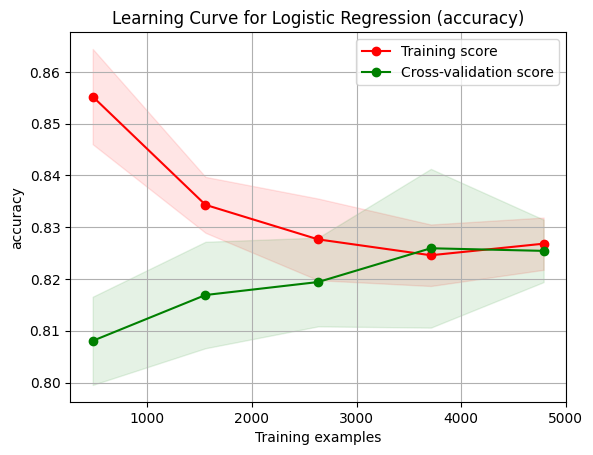

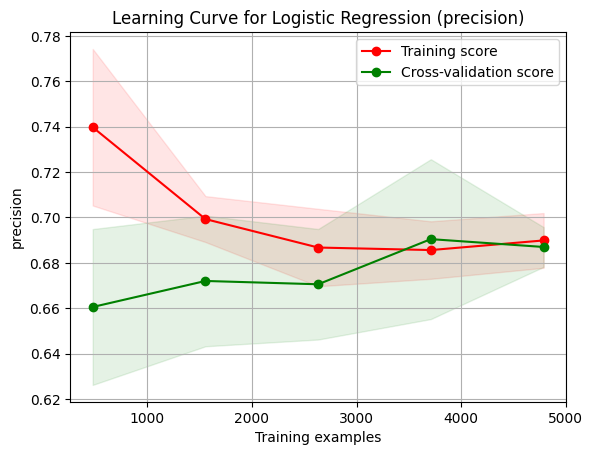

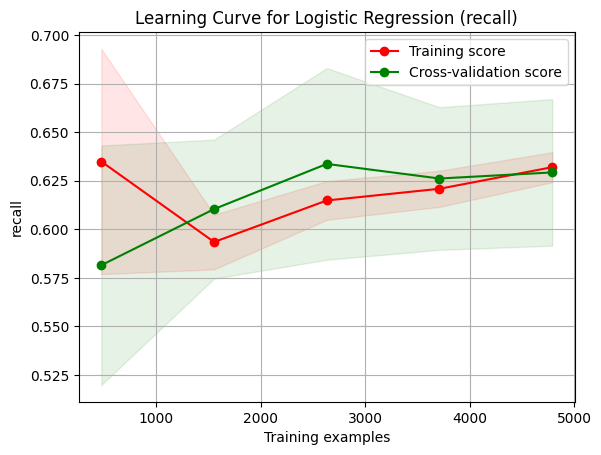

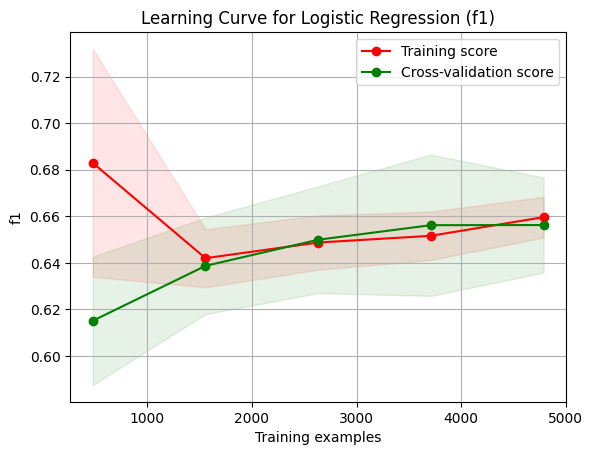

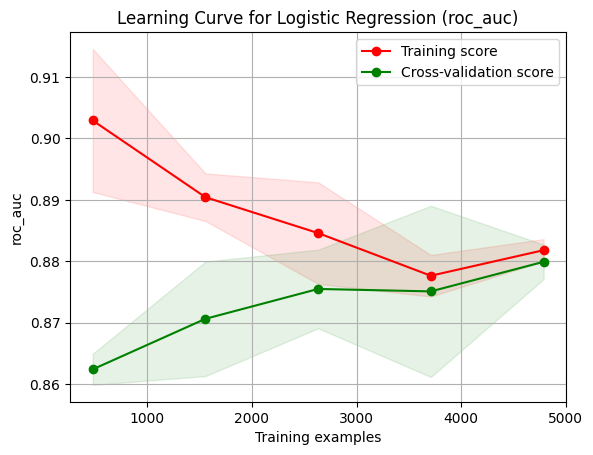

In [54]:
# Step 4: Plot learning curves for different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics:
    plot_learning_curve(model_pipe, f'Learning Curve for Logistic Regression ({metric})', X_train, y_train, cv=5, scoring=metric)
    plt.show()

Feature importance

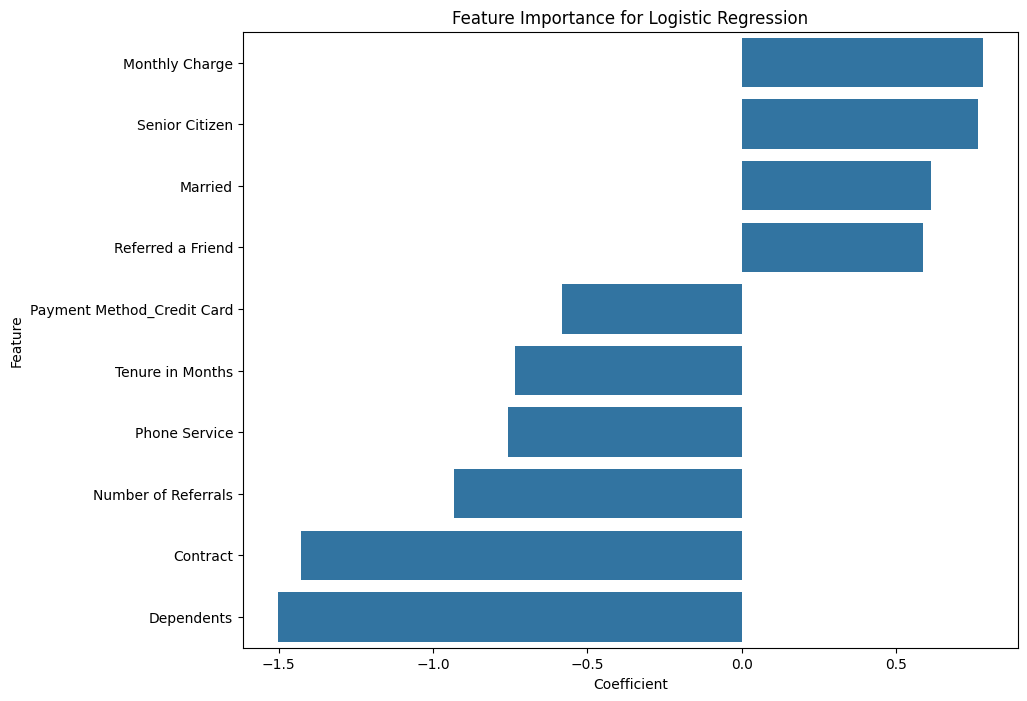

In [55]:
# Visualize feature importance
coefficients = final_model_pipe.named_steps['model'].coef_[0]
importance_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance for Logistic Regression')
plt.show()


Model metrics

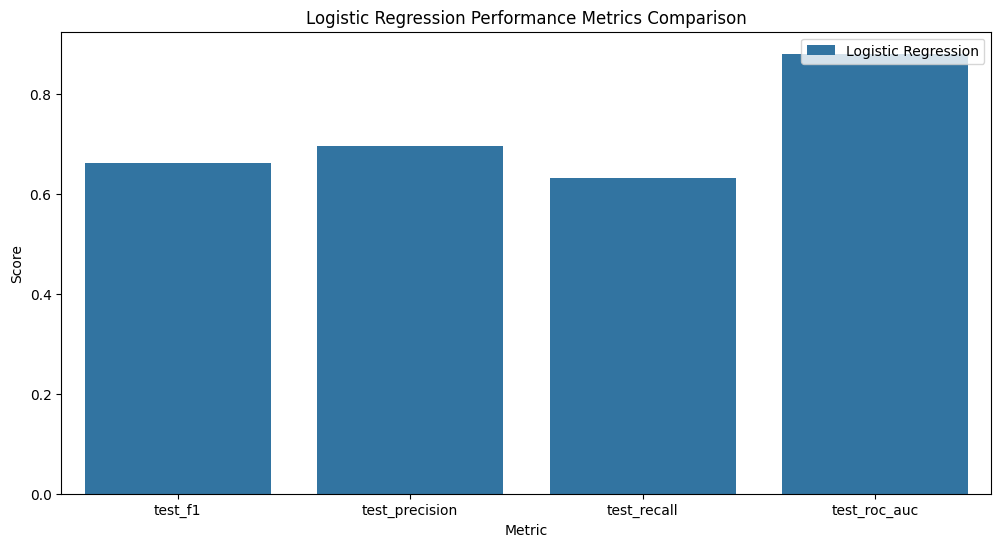

In [56]:
# Convert the cross-validation results to long format
cv_df_long_LR = pd.melt(cv_df_fs_LR, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Define the desired order of metrics
desired_order = ['test_f1', 'test_precision', 'test_recall', 'test_roc_auc']

# Convert the 'Attribute' column to a categorical type with the specified order
cv_df_long_LR['Attribute'] = pd.Categorical(cv_df_long_LR['Attribute'], categories=desired_order, ordered=True)

# Plot performance metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=cv_df_long_LR)
plt.title('Logistic Regression Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

Combined Metrics


In [57]:
# Convert Logistic Regression cross-validation results to long format
cv_df_long_LR = pd.melt(cv_df_fs_LR, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Convert other models' cross-validation results to long format
cv_df_long_other = pd.melt(score_fs, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Ensure there are no duplicate entries
cv_df_long_LR = cv_df_long_LR.drop_duplicates(subset=['Attribute', 'Model'])
cv_df_long_other = cv_df_long_other.drop_duplicates(subset=['Attribute', 'Model'])

# Combine the two DataFrames
combined_df_long = pd.concat([cv_df_long_LR, cv_df_long_other], axis=0)

# Reset index to ensure no duplicate indices
combined_df_long = combined_df_long.reset_index(drop=True)

# Define the desired order of metrics
desired_order = ['test_f1', 'test_precision', 'test_recall', 'test_roc_auc']

# Convert the 'Attribute' column to a categorical type with the specified order
combined_df_long['Attribute'] = pd.Categorical(combined_df_long['Attribute'], categories=desired_order, ordered=True)

# Plot performance metrics comparison for all models
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=combined_df_long)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

NameError: name 'score_fs' is not defined

ROC AUC curve

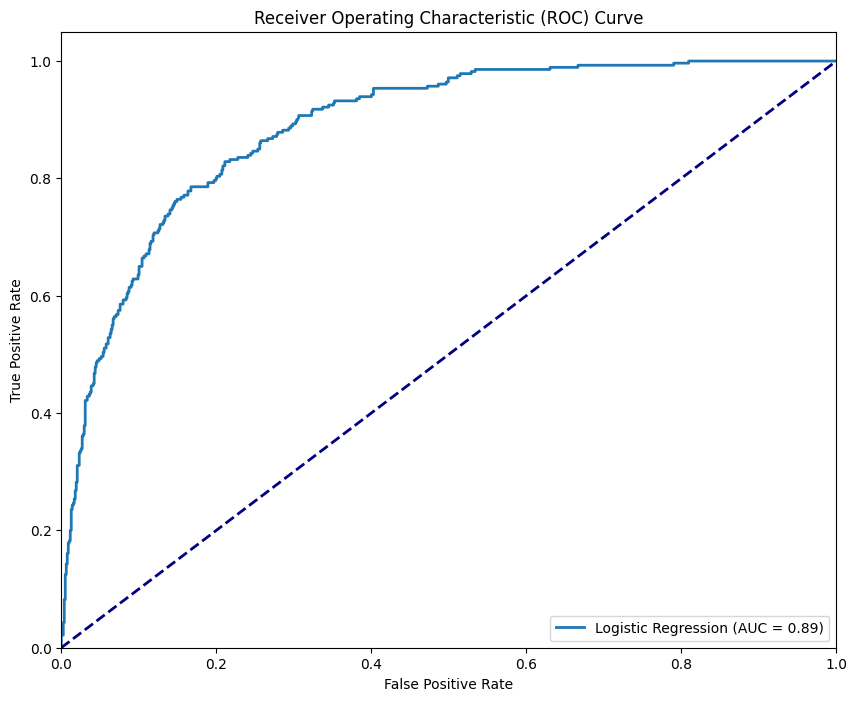

In [58]:
# Plot ROC curve for Logistic Regression
plt.figure(figsize=(10, 8))

# Define the Logistic Regression pipeline
model_pipe = Pipeline(steps=[
    ('preprocessor', combined_preprocessor),
    ('feature_selection', feature_selector),
    ('model', model)
])

# Fit the pipeline on the training data
model_pipe.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()

Combined ROC AUC curves

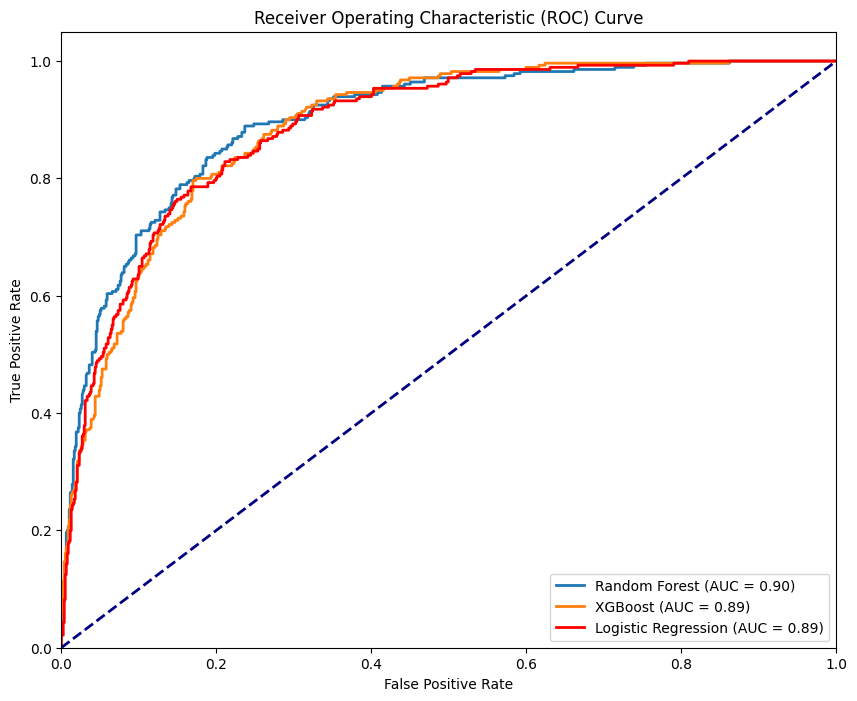

In [59]:
# Initialize the figure
plt.figure(figsize=(10, 8))

# Plot ROC curves for other models in feature_selection_models
for name, model in feature_selection_models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for Logistic Regression
# Define the Logistic Regression pipeline
model_pipe_lr = Pipeline(steps=[
    ('preprocessor', combined_preprocessor),
    ('feature_selection', feature_selector),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline on the training data
model_pipe_lr.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba_lr = model_pipe_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot the ROC curve for Logistic Regression
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='red')  # Use a distinct color

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()

### Feature Selection with Satisfaction Score

Model Fit, Feature Importance and Cross Validation

In [61]:
# Define the order for ordinal variables
## excluded variables: 'Churn Value', 'Customer ID'
ord_ = {
    'ord1': [['Married', 'Dependents', 'Referred a Friend', 'Phone Service', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data', 'Under 30', 'Online Security',
             'Online Backup','Streaming TV', 'Multiple Lines', 'Internet Service','Device Protection Plan', 'Streaming Movies', 'Paperless Billing', 'Senior Citizen', 
             'Total Extra Data Charges','Total Refunds'], ['No', 'Yes']],
    'ord2': [['Internet Type'], ['None', 'DSL', 'Cable', 'Fiber Optic']], # MAKE SURE THE SPEED OF THE INTERNET TYPE INCREASING
    'ord3': [['Contract'], ['Month-to-Month', 'One Year', 'Two Year']],
    'ord4': [['Satisfaction Score'], ['1', '2', '3', '4', '5']]
    
}


nominal_var = ['Offer', 'Gender', 'Payment Method']


numeric_var = ['Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 
               'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Long Distance Charges', 'Total Revenue', 'Age', 'Number of Dependents']

In [62]:
# Ensure 'Satisfaction Score' is also treated as a categorical variable
df_transform['Satisfaction Score'] = df_transform['Satisfaction Score'].astype('category')

In [ ]:
# Combine all ordinal variables into one list and their respective order categories
ordinal_var = []
ord_categories = []
for key in ord_:
    ordinal_var += ord_[key][0]
    ord_categories += [ord_[key][1]] * len(ord_[key][0])


# Define function to find outliers
def find_outliers_IQR(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function for handling outliers
def func_handling_outlier(X):
    X = X.copy()
    X['Number of Dependents'] = X['Number of Dependents'].apply(lambda i: 3 if i > 3 else i)
    out_var3 = ['Number of Referrals', 'Total Long Distance Charges', 'Avg Monthly GB Download', 'Total Revenue']
    upper_bound = []
    for i in out_var3:
        upper_bound.append(int(find_outliers_IQR(X[i])[2]))
    for i, j in zip(out_var3, upper_bound):
        X.loc[X[X[i] > j].index.to_list(), i] = np.NaN
    imputer = KNNImputer(n_neighbors=7)
    X[out_var3] = imputer.fit_transform(X[out_var3])
    return X

# Split dataset
X = df_transform[numeric_var + nominal_var + ordinal_var]
y = df_transform['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Ensure data is in DataFrame format
X_train = pd.DataFrame(X_train, columns=numeric_var + nominal_var + ordinal_var)
X_test = pd.DataFrame(X_test, columns=numeric_var + nominal_var + ordinal_var)

# Preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=ord_categories))
])

# Column transformer for preprocessing
prep_var = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_var),
        ('nominal', nominal_pipeline, nominal_var),
        ('ordinal', ordinal_pipeline, ordinal_var)
    ], remainder='passthrough'
)

# Pipeline for handling outliers
hand_outliers = Pipeline(steps=[
    ('handling_outlier', FunctionTransformer(func_handling_outlier))
])

# Combined preprocessor
combined_preprocessor = Pipeline(steps=[
    ('hand_outliers', hand_outliers),
    ('prep_var', prep_var)
])

# Fit the combined preprocessor first
combined_preprocessor.fit(X_train)

# Extract feature names after fitting the combined preprocessor
nominal_feature_names = combined_preprocessor.named_steps['prep_var'].named_transformers_['nominal'].named_steps['encoder'].get_feature_names_out(nominal_var)
feature_names = numeric_var + list(nominal_feature_names) + ordinal_var

# Feature selection models
feature_selection_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,  # Increased number of trees
        max_depth=10,  # No limit on the depth of the trees
        min_samples_split=10,  # Lowered to allow more splits
        random_state=42
)
,
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        n_estimators=200,  # Increased number of boosting rounds
        max_depth=6,  # Keep the same depth
        min_child_weight=5,  # Reduced to allow more splits
        subsample=0.8,  # Keep the same subsample ratio
        learning_rate=0.1,  # Introduce a learning rate
        random_state=42
    )
}




cv_df_fs = []
for name, model in feature_selection_models.items():
    feature_selector = SelectFromModel(model, threshold='mean')
    
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)
    ])
    
    # Perform cross-validation
    score = cross_validate(model_pipe, X_train, y_train, cv=10, return_train_score=False, scoring=['roc_auc', 'f1', 'recall', 'precision'])
    mean_score = []
    for i in score.values():
        mean_score.append(round(np.mean(i), 3))
    cv_df_fs.append(pd.DataFrame({'Attribute': [i for i in score.keys()], f'{name}': mean_score}))

score_fs = pd.DataFrame(columns=['Attribute'])
for i in cv_df_fs:
    score_fs = score_fs.merge(right=i, on='Attribute', how='outer')
score_fs = score_fs.loc[2:].reset_index(drop=True)

print("Feature Selection Model Cross-Validation Results:")
print(score_fs)





model_pipes = {}
# Fitting the feature selection models and evaluating on the test set
for name, model in feature_selection_models.items():
    feature_selector = SelectFromModel(model, threshold='mean')
    
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)
    ])
    
    model_pipe.fit(X_train, y_train)
    model_pipes[name] = model_pipe
    
    # Extract selected feature names
    selected_mask = model_pipe.named_steps['feature_selection'].get_support()
    selected_features = [feature for feature, selected in zip(feature_names, selected_mask) if selected]

    print(f"Selected Features for {name}: {selected_features}")

    # Transform the training and testing sets using the entire pipeline
    X_train_transformed = model_pipe.named_steps['preprocessor'].transform(X_train)
    X_test_transformed = model_pipe.named_steps['preprocessor'].transform(X_test)

    # Transform using the feature selector
    X_train_selected = model_pipe.named_steps['feature_selection'].transform(X_train_transformed)
    X_test_selected = model_pipe.named_steps['feature_selection'].transform(X_test_transformed)

    # Create a new model pipeline with only the selected features
    final_model_pipe = Pipeline(steps=[
        ('model', model)
    ])

    # Fit the final model on the selected features
    final_model_pipe.fit(X_train_selected, y_train)

    # Evaluate the final model on the test set
    y_pred = final_model_pipe.predict(X_test_selected)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, y_pred))

    # Plot feature importances of the selected features
    importances = model_pipe.named_steps['feature_selection'].estimator_.feature_importances_
    selected_importances = [importance for importance, selected in zip(importances, selected_mask) if selected]
    importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': selected_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance for {name}')
    plt.show()

Model metrics

In [ ]:
# Convert cross-validation results to DataFrame
cv_df_long = pd.melt(score_fs, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Plot performance metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=cv_df_long)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

Learning Curves

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\pipeline.py", line 541, in fit_transform
    return last_step.fit_transform(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\compose\_column_transformer.py", line 976, in fit_transform
    result = self._call_func_on_transformers(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\compose\_column_transformer.py", line 885, in _call_func_on_transformers
    return Parallel(n_jobs=self.n_jobs)(jobs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\utils\parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\joblib\parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\joblib\parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\utils\parallel.py", line 136, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\pipeline.py", line 541, in fit_transform
    return last_step.fit_transform(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\preprocessing\_encoders.py", line 1496, in fit
    fit_results = self._fit(
                  ^^^^^^^^^^
  File "c:\Users\Ruta\Documents\Data Science Exam\venv-datascience\Lib\site-packages\sklearn\preprocessing\_encoders.py", line 160, in _fit
    raise ValueError(msg)
ValueError: Found unknown categories [nan] in column 19 during fit


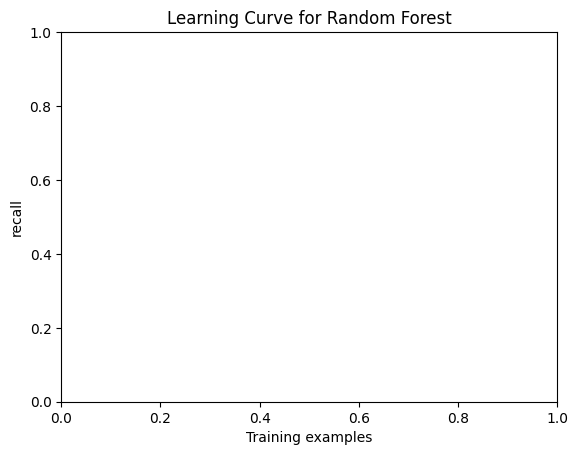

In [65]:
# Define a function to plot the learning curve with a specific scoring metric
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring if scoring else "Score")  # Display the scoring metric used
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot learning curves for each model with scoring='recall'
for name, model in feature_selection_models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)
    ])
    plot_learning_curve(model_pipe, f'Learning Curve for {name}', X_train, y_train, cv=5, scoring='recall')
    plt.show()


Logistic Regression

In [ ]:
# Combine all ordinal variables into one list and their respective order categories
ordinal_var = []
ord_categories = []
for key in ord_:
    ordinal_var += ord_[key][0]
    ord_categories += [ord_[key][1]] * len(ord_[key][0])

# Define function to find outliers
def find_outliers_IQR(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function for handling outliers
def func_handling_outlier(X):
    X = X.copy()
    X['Number of Dependents'] = X['Number of Dependents'].apply(lambda i: 3 if i > 3 else i)
    out_var3 = ['Number of Referrals', 'Total Long Distance Charges', 'Avg Monthly GB Download', 'Total Revenue']
    upper_bound = []
    for i in out_var3:
        upper_bound.append(int(find_outliers_IQR(X[i])[2]))
    for i, j in zip(out_var3, upper_bound):
        X.loc[X[X[i] > j].index.to_list(), i] = np.NaN
    imputer = KNNImputer(n_neighbors=7)
    X[out_var3] = imputer.fit_transform(X[out_var3])
    return X

# Split dataset
X = df_transform[numeric_var + nominal_var + ordinal_var]
y = df_transform['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Ensure data is in DataFrame format
X_train = pd.DataFrame(X_train, columns=numeric_var + nominal_var + ordinal_var)
X_test = pd.DataFrame(X_test, columns=numeric_var + nominal_var + ordinal_var)

# Preprocessing pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline(steps=[

    ('encoder', OrdinalEncoder(categories=ord_categories))
])

# Column transformer for preprocessing
prep_var = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_var),
        ('nominal', nominal_pipeline, nominal_var),
        ('ordinal', ordinal_pipeline, ordinal_var)
    ], remainder='passthrough'
)

# Pipeline for handling outliers
hand_outliers = Pipeline(steps=[
    ('handling_outlier', FunctionTransformer(func_handling_outlier))
])

# Combined preprocessor
combined_preprocessor = Pipeline(steps=[
    ('hand_outliers', hand_outliers),
    ('prep_var', prep_var)
])

# Fit the combined preprocessor first
combined_preprocessor.fit(X_train)

# Extract feature names after fitting the combined preprocessor
nominal_feature_names = combined_preprocessor.named_steps['prep_var'].named_transformers_['nominal'].named_steps['encoder'].get_feature_names_out(nominal_var)
feature_names = numeric_var + list(nominal_feature_names) + ordinal_var

# Feature selection with Logistic Regression using RFE
model = LogisticRegression(max_iter=1000, random_state=42)
feature_selector = RFE(model, n_features_to_select=10)  # Select top 10 features

model_pipe = Pipeline(steps=[
    ('preprocessor', combined_preprocessor),
    ('feature_selection', feature_selector),
    ('model', model)
])

cv_df_fs_LR = []

# Perform cross-validation
score = cross_validate(model_pipe, X_train, y_train, cv=10, return_train_score=False, scoring=['roc_auc', 'f1', 'recall', 'precision'])

# Convert cross-validation results to DataFrame
cv_df_fs_LR = pd.DataFrame({
    'Attribute': [i for i in score.keys()],
    'Logistic Regression': [round(np.mean(score[i]), 3) for i in score.keys()]
})

print("Feature Selection Model Cross-Validation Results:")
print(cv_df_fs_LR)

# Directly assign to score_fs_LR
score_fs_LR = cv_df_fs_LR.loc[2:].reset_index(drop=True)

# Fitting the feature selection model and evaluating on the test set
model_pipe.fit(X_train, y_train)

# Extract selected feature names
selected_mask = model_pipe.named_steps['feature_selection'].get_support()
selected_features = [feature for feature, selected in zip(feature_names, selected_mask) if selected]

print(f"Selected Features for Logistic Regression: {selected_features}")

# Transform the training and testing sets using the entire pipeline
X_train_transformed = model_pipe.named_steps['preprocessor'].transform(X_train)
X_test_transformed = model_pipe.named_steps['preprocessor'].transform(X_test)

# Transform using the feature selector
X_train_selected = model_pipe.named_steps['feature_selection'].transform(X_train_transformed)
X_test_selected = model_pipe.named_steps['feature_selection'].transform(X_test_transformed)

# Create a new model pipeline with only the selected features
final_model_pipe = Pipeline(steps=[
    ('model', model)
])

# Fit the final model on the selected features
final_model_pipe.fit(X_train_selected, y_train)

# Evaluate the final model on the test set
y_pred = final_model_pipe.predict(X_test_selected)
print(f"Classification report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Learning Curves

In [ ]:

# Plot learning curves for different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics:
    plot_learning_curve(model_pipe, f'Learning Curve for Logistic Regression ({metric})', X_train, y_train, cv=5, scoring=metric)
    plt.show()


Model Metrics

In [ ]:
# Convert the cross-validation results to long format
cv_df_long_LR = pd.melt(cv_df_fs_LR, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Define the desired order of metrics
desired_order = ['test_f1', 'test_precision', 'test_recall', 'test_roc_auc']

# Convert the 'Attribute' column to a categorical type with the specified order
cv_df_long_LR['Attribute'] = pd.Categorical(cv_df_long_LR['Attribute'], categories=desired_order, ordered=True)

# Plot performance metrics comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=cv_df_long_LR)
plt.title('Logistic Regression Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

Combined Models metrics

In [ ]:
# Convert Logistic Regression cross-validation results to long format
cv_df_long_LR = pd.melt(cv_df_fs_LR, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Convert other models' cross-validation results to long format
cv_df_long_other = pd.melt(score_fs, id_vars=["Attribute"], var_name="Model", value_name="Score")

# Ensure there are no duplicate entries
cv_df_long_LR = cv_df_long_LR.drop_duplicates(subset=['Attribute', 'Model'])
cv_df_long_other = cv_df_long_other.drop_duplicates(subset=['Attribute', 'Model'])

# Combine the two DataFrames
combined_df_long = pd.concat([cv_df_long_LR, cv_df_long_other], axis=0)

# Reset index to ensure no duplicate indices
combined_df_long = combined_df_long.reset_index(drop=True)

# Define the desired order of metrics
desired_order = ['test_f1', 'test_precision', 'test_recall', 'test_roc_auc']

# Convert the 'Attribute' column to a categorical type with the specified order
combined_df_long['Attribute'] = pd.Categorical(combined_df_long['Attribute'], categories=desired_order, ordered=True)

# Plot performance metrics comparison for all models
plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="Score", hue="Model", data=combined_df_long)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper right')
plt.show()

ROC AUC Curves

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in feature_selection_models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot ROC curve for Logistic Regression
plt.figure(figsize=(10, 8))

# Define the Logistic Regression pipeline
model_pipe = Pipeline(steps=[
    ('preprocessor', combined_preprocessor),
    ('feature_selection', feature_selector),
    ('model', model)
])

# Fit the pipeline on the training data
model_pipe.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()

Combined ROC AUC curves

In [ ]:
# Initialize the figure
plt.figure(figsize=(10, 8))

# Plot ROC curves for other models in feature_selection_models
for name, model in feature_selection_models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessor', combined_preprocessor),
        ('feature_selection', feature_selector),
        ('model', model)])
    model_pipe.fit(X_train, y_train)
    
    y_pred_proba = model_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for Logistic Regression
# Define the Logistic Regression pipeline
model_pipe_lr = Pipeline(steps=[
    ('preprocessor', combined_preprocessor),
    ('feature_selection', feature_selector),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline on the training data
model_pipe_lr.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba_lr = model_pipe_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot the ROC curve for Logistic Regression
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='red')  # Use a distinct color

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()

Feature importance

In [ ]:
# Visualize feature importance
coefficients = final_model_pipe.named_steps['model'].coef_[0]
importance_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance for Logistic Regression')
plt.show()